# Preprocess data

In [5]:
from typing import TYPE_CHECKING, Tuple, Union, Optional
from pathlib import Path

if TYPE_CHECKING:
    import numpy.typing as npt

import h5py  # type: ignore[import]
import numpy as np
from scipy.sparse import coo_matrix  # type: ignore[import]
from tqdm import tqdm

PathLike = Union[Path, str]


def sparse_to_dense(
    h5_file: PathLike,
    dataset_name: str,
    initial_shape: Tuple[int, int],
    final_shape: Union[Tuple[int, int, int], Tuple[int, int]],
    values_dataset_name: Optional[str] = None,
) -> "npt.ArrayLike":
    """Convert sparse COO formatted contact maps to dense.

    Parameters
    ----------
    h5_file : PathLike
        The HDF5 file containing contact maps.
    dataset_name : str
        The dataset name containing the contact map indices.
    initial_shape : Tuple[int, int]
        The shape of the contact map saved in the HDF5 file.
    final_shape : Union[Tuple[int, int, int], Tuple[int, int]]
        The final shape of the contact map incase adding an extra
        dimension is necessary e.g. (D, D, 1) where D is the number
        of residues or the cropping shape.
    values_dataset_name: Optional[str], default=None
        Name of dataset containing the values of the sparse matrix.
        By default, it autofills with 1.

    Returns
    -------
    npt.ArrayLike
        The output array of contact maps of shape (N, D, D) or
        (N, D, D, 1) depending on :obj:`final_shape` where N is
        the number of contact maps in the HDF5 file.
    """
    contact_maps = []
    with h5py.File(h5_file, "r", libver="latest", swmr=False) as f:
        
        # Read all data into memory at once
        dataset = f[dataset_name][...]
        if values_dataset_name is not None:
            values_dataset = f[values_dataset_name][...]
        
        for i, raw_indices in tqdm(enumerate(dataset)):
            indices = raw_indices.reshape((2, -1)).astype("int16")
            
            if values_dataset_name is None:
                # Contact matrices are binary so we don't need to store the values
                # in HDF5 format. Instead we create a vector of 1s on the fly.
                values = np.ones(indices.shape[1]).astype("byte")
            else:
                values = values_dataset[i]

            # Construct COO formated sparse matrix
            contact_map = coo_matrix(
                (values, (indices[0], indices[1])), shape=initial_shape
            ).todense()
            # Crop and reshape incase of extra 1 e.g. (N, N, 1)
            contact_map = np.array(
                contact_map[: final_shape[0], : final_shape[1]], dtype=np.float16
            ).reshape(final_shape)
            contact_maps.append(contact_map)
    return np.array(contact_maps)

In [6]:
contact_maps = sparse_to_dense(
    h5_file="/lambda_stor/homes/abrace/data/bba/1FME-0.h5",
    dataset_name="contact_map",
    initial_shape=(28, 28),
    final_shape=(28, 28),
    values_dataset_name="contact_map_values",
) 

1114545it [00:57, 19424.59it/s]


In [7]:
contact_maps.shape

(1114545, 28, 28)

In [8]:
import matplotlib.pyplot as plt

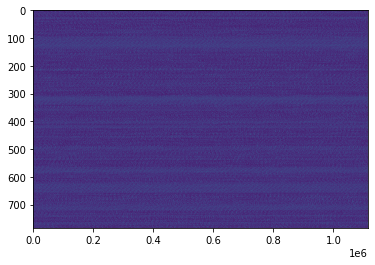

In [9]:
plt.imshow(contact_maps[::1].astype("float32").reshape(28*28, -1), aspect='auto')

In [10]:
# To input to FNO, the data must have shape (N, 28, 28, T)
# Pick T=50, to mimic the 2D Navier-Stokes equation example
# found here: https://github.com/zongyi-li/fourier_neural_operator/tree/master

T = 50 # Number of time steps per example
M = contact_maps.shape[1] # Number of residues
N = len(contact_maps) # Total number of contact maps

print(T, M, N)

50 28 1114545


In [11]:
fno_input = np.array([contact_maps[i * T: (i + 1) * T] for i in range(N // T)]).reshape(-1, M, M, T)
fno_input.shape

(22290, 28, 28, 50)

In [12]:
np.save("bba_fno_input.npy", fno_input)

In [13]:
fno_input = np.load("bba_fno_input.npy").astype("float32")
fno_input.shape

(22290, 28, 28, 50)

In [ ]:
# Take Every other residue to get (N, 14, 14, 50)
# Then test super resolution on (N, 28, 28, 50)

# Then test time-super-resolution
# Train on: (N, 28, 28, 50)
# Test on: (N, 28, 28, 100)

# Train model

In [99]:
"""
@author: Zongyi Li
This file is the Fourier Neural Operator for 2D problem such as the Navier-Stokes equation discussed in Section 5.3 in the [paper](https://arxiv.org/pdf/2010.08895.pdf),
which uses a recurrent structure to propagates in time.
"""


import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from utilities3 import *

import operator
from functools import reduce
from functools import partial

from timeit import default_timer

from Adam import Adam

torch.manual_seed(0)
np.random.seed(0)


################################################################
# fourier layer
################################################################

class SpectralConv2d_fast(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d_fast, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels,  x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        #Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

class FNO2d(nn.Module):
    def __init__(self, modes1, modes2, width, timesteps: int):
        super(FNO2d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the previous 10 timesteps + 2 locations (u(t-10, x, y), ..., u(t-1, x, y),  x, y)
        input shape: (batchsize, x=64, y=64, c=12)
        output: the solution of the next timestep
        output shape: (batchsize, x=64, y=64, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.padding = 2 # pad the domain if input is non-periodic
        #self.fc0 = nn.Linear(12, self.width)
        # +2 because the grid (we think)
        self.fc0 = nn.Linear(timesteps + 2, self.width)
        # input channel is 12: the solution of the previous 10 timesteps + 2 locations (u(t-10, x, y), ..., u(t-1, x, y),  x, y)

        self.conv0 = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)
        self.bn0 = torch.nn.BatchNorm2d(self.width)
        self.bn1 = torch.nn.BatchNorm2d(self.width)
        self.bn2 = torch.nn.BatchNorm2d(self.width)
        self.bn3 = torch.nn.BatchNorm2d(self.width)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)
        # x = F.pad(x, [0,self.padding, 0,self.padding]) # pad the domain if input is non-periodic

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2

        # x = x[..., :-self.padding, :-self.padding] # pad the domain if input is non-periodic
        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x

    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)



In [100]:
ntrain = 17832
ntest = 4457

modes = 12
width = 20 # 25 + 25, this also doesn't work

batch_size = 128
batch_size2 = batch_size

epochs = 500
learning_rate = 0.001
scheduler_step = 100
scheduler_gamma = 0.5

sub = 1
S = 28
T_in = 25
T = 25
step = 1

In [101]:
fno_input.shape

(22290, 28, 28, 50)

In [102]:
train_split_ptc = 0.8
fno_input_train = fno_input[: int(train_split_ptc * len(fno_input))]
fno_input_test = fno_input[: int((1- train_split_ptc) * len(fno_input))]
print(fno_input_train.shape)
print(fno_input_test.shape)

(17832, 28, 28, 50)
(4457, 28, 28, 50)


In [103]:
train_a = fno_input_train[:ntrain,::sub,::sub,:T_in]
train_u = fno_input_train[:ntrain,::sub,::sub,T_in:T+T_in]

test_a = fno_input_test[-ntest:,::sub,::sub,:T_in]
test_u = fno_input_test[-ntest:,::sub,::sub,T_in:T+T_in]

print(train_a.shape)
print(train_u.shape)

print(test_a.shape)
print(test_u.shape)

assert (S == train_u.shape[-2])
assert (T == train_u.shape[-1])

train_a = torch.from_numpy(train_a)
train_u = torch.from_numpy(train_u)
test_a = torch.from_numpy(test_a)
test_u = torch.from_numpy(test_u)

train_dataset = torch.utils.data.TensorDataset(train_a, train_u)
test_dataset = torch.utils.data.TensorDataset(test_a, test_u)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, drop_last=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, drop_last=True
)

(17832, 28, 28, 25)
(17832, 28, 28, 25)
(4457, 28, 28, 25)
(4457, 28, 28, 25)


In [104]:
model = FNO2d(modes, modes, width, T_in).cuda()

In [105]:
print(model)

FNO2d(
  (fc0): Linear(in_features=27, out_features=20, bias=True)
  (conv0): SpectralConv2d_fast()
  (conv1): SpectralConv2d_fast()
  (conv2): SpectralConv2d_fast()
  (conv3): SpectralConv2d_fast()
  (w0): Conv2d(20, 20, kernel_size=(1, 1), stride=(1, 1))
  (w1): Conv2d(20, 20, kernel_size=(1, 1), stride=(1, 1))
  (w2): Conv2d(20, 20, kernel_size=(1, 1), stride=(1, 1))
  (w3): Conv2d(20, 20, kernel_size=(1, 1), stride=(1, 1))
  (bn0): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)


In [106]:
print(count_params(model))
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step, gamma=scheduler_gamma)

466017


In [ ]:
myloss = LpLoss(size_average=False)
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_l2_step = 0
    train_l2_full = 0
    for xx, yy in train_loader:
        loss = 0
        xx = xx.to(device)
        yy = yy.to(device)

        for t in range(0, T, step):
            y = yy[..., t:t + step]
            im = model(xx)
            loss += myloss(im.reshape(batch_size, -1), y.reshape(batch_size, -1))

            if t == 0:
                pred = im
            else:
                pred = torch.cat((pred, im), -1)

            xx = torch.cat((xx[..., step:], im), dim=-1)

        train_l2_step += loss.item()
        l2_full = myloss(pred.reshape(batch_size, -1), yy.reshape(batch_size, -1))
        train_l2_full += l2_full.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    test_l2_step = 0
    test_l2_full = 0
    with torch.no_grad():
        for xx, yy in test_loader:
            loss = 0
            xx = xx.to(device)
            yy = yy.to(device)

            for t in range(0, T, step):
                y = yy[..., t:t + step]
                im = model(xx)
                loss += myloss(im.reshape(batch_size, -1), y.reshape(batch_size, -1))

                if t == 0:
                    pred = im
                else:
                    pred = torch.cat((pred, im), -1)

                xx = torch.cat((xx[..., step:], im), dim=-1)

            test_l2_step += loss.item()
            test_l2_full += myloss(pred.reshape(batch_size, -1), yy.reshape(batch_size, -1)).item()

    t2 = default_timer()
    scheduler.step()
    print(ep, t2 - t1, train_l2_step / ntrain / (T / step), train_l2_full / ntrain, test_l2_step / ntest / (T / step),
          test_l2_full / ntest)

0 42.57619410427287 0.5600005317643492 0.5610016356032224 0.3629829070887438 0.36463208334419744
1 41.39348388463259 0.34735049727359874 0.3492256075130444 0.31903248445212584 0.3208969155581831
2 40.85393837792799 0.32138146504418846 0.32346864942479636 0.30546284833723636 0.3075186353053965
3 41.093955531250685 0.310796272069042 0.3130599625605861 0.2981922369964031 0.30040747642731064
4 41.65451952069998 0.304588482301831 0.3069883355542436 0.2935239538270207 0.29583971581171253
5 39.60667663626373 0.3004838221786588 0.30297776047238967 0.28998193841411685 0.2923473086837484
6 42.00424356525764 0.2973024951358075 0.2998651151113737 0.28717415141823954 0.289581802946745
7 42.06210457580164 0.2947599007292893 0.2973766213524443 0.28486446552648925 0.2873396951573992
8 40.37787359813228 0.2925915320607353 0.2952520155275601 0.2828634638761709 0.285358727232394
9 42.30143725220114 0.29063706875061335 0.29333411229999146 0.2811494822049585 0.2837140457978397
10 41.902884180191904 0.28882

In [ ]:
# generate figure 1
# relative error wrt epoch (loss curve)

In [74]:
epoch_prints_cm = """0 0.939223940949887 1.05351884765625 1.05351611328125 1.1912274780273437 1.1912227630615235
1 0.8741427985951304 0.9106588623046875 0.9106299209594727 1.1061193237304687 1.106026840209961
2 0.8780943262390792 0.8776185668945313 0.877597053527832 1.0792062377929688 1.0793484497070311
3 0.8755378858186305 0.8080617492675781 0.8084004974365234 0.8719038696289063 0.8722678375244141
4 0.8783394210040569 0.6640652526855468 0.6644731216430664 0.7584796752929688 0.7589592361450195
5 0.8779750871472061 0.5912108947753907 0.591575813293457 0.6782652282714844 0.6790246200561524
6 0.8756172601133585 0.5346915649414062 0.5350673370361329 0.6050142211914062 0.6055830764770508
7 0.8741823467426002 0.49078965454101564 0.4911787567138672 0.5499752502441406 0.5507395935058593
8 0.8767294976860285 0.4573361389160156 0.4578561897277832 0.516920166015625 0.5180213928222657
9 0.8772292979992926 0.4336860168457031 0.4342591667175293 0.500934814453125 0.5020752906799316
10 0.8746393318288028 0.4177266357421875 0.4183000411987305 0.4826545257568359 0.48377676010131837
11 0.8786501791328192 0.40472624511718747 0.4053092651367188 0.4707924041748047 0.471942138671875
12 0.8773620678111911 0.3932458404541016 0.39383568572998046 0.4623781433105469 0.46353994369506835
13 0.880437848623842 0.3829629852294922 0.38358105850219726 0.4528500518798828 0.45406452178955076
14 0.8778932630084455 0.3732103515625 0.3738522605895996 0.44490585327148435 0.4461673736572266
15 0.8832850311882794 0.3643077117919922 0.36499226379394534 0.4373973083496094 0.4387337303161621
16 0.9064289601519704 0.35588859252929683 0.35661080169677734 0.4312921905517578 0.43266237258911133
17 0.9053580150939524 0.3483025665283203 0.3490414810180664 0.42491990661621093 0.4263676643371582
18 0.9049948807805777 0.34112650451660154 0.3418906669616699 0.41940083312988286 0.4208774375915527
19 0.9074585591442883 0.33470457153320315 0.3354975776672363 0.414645751953125 0.4161540985107422
20 0.9035422708839178 0.3292249053955078 0.3300416259765625 0.40973200988769526 0.41128351211547853
21 0.8988365959376097 0.32400496826171876 0.3248405838012695 0.40581216430664063 0.40739677429199217
22 0.882313669193536 0.319675146484375 0.32053074645996094 0.40251741027832033 0.4041356658935547
23 0.8858462222851813 0.31581867065429686 0.3166974220275879 0.39938816833496094 0.40102222442626956
24 0.8871884606778622 0.3123525177001953 0.3132536544799805 0.3967489929199219 0.39839725494384765
25 0.8852245309390128 0.30950226135253905 0.3104114646911621 0.3942161102294922 0.39587055206298827
26 0.9642013851553202 0.30682235107421874 0.30773946380615236 0.39204367065429685 0.39372840881347654
27 1.0174444178119302 0.30464703674316407 0.3055842247009277 0.39009034729003905 0.3917738151550293
28 0.9576583108864725 0.3024519744873047 0.3033942909240723 0.3882261962890625 0.38992149353027344
29 0.9253500485792756 0.300512939453125 0.30146901321411135 0.3868236389160156 0.38853599548339846
30 0.9603221882134676 0.29876138916015627 0.29972735977172854 0.385093765258789 0.38681100845336913
31 0.9017781401053071 0.29730913696289063 0.2982767524719238 0.38383361816406253 0.3855626678466797
32 0.9139940347522497 0.29598915100097656 0.29695865631103513 0.38265789794921873 0.3844027137756348
33 0.9310634518042207 0.29451314697265624 0.29549386978149417 0.3819224853515625 0.383681640625
34 0.929121439345181 0.2933734497070312 0.29436344146728516 0.38063612365722654 0.3824115753173828
35 0.9151615779846907 0.29229368896484376 0.2932860870361328 0.3799066772460938 0.38166959762573244
36 0.897746185772121 0.2914413421630859 0.2924521484375 0.3787436218261719 0.38051279067993166
37 0.9195042476058006 0.2901245391845703 0.29112451934814454 0.37790139770507813 0.3796773338317871
38 0.9494998753070831 0.28924443969726565 0.29025499725341797 0.37711956787109374 0.3789107131958008
39 0.9414163632318377 0.28831201477050783 0.2893296432495117 0.37639068603515624 0.37819681167602537
40 0.9420651979744434 0.2875112335205078 0.28854156494140626 0.3756617889404297 0.3774625015258789
41 0.9418427268974483 0.28682484436035155 0.2878546104431152 0.375052001953125 0.37687034606933595
42 0.934863397385925 0.2861333038330078 0.28716861343383787 0.3744655151367188 0.3762751007080078
43 0.9427687362767756 0.28538683776855467 0.28642681121826175 0.3738536376953125 0.3756743049621582
44 0.9015638730488718 0.2844661651611328 0.2855196647644043 0.3732126159667969 0.37503925323486326
45 0.8944744737818837 0.2837457977294922 0.2848032760620117 0.3726471405029297 0.3744638442993164
46 0.8942400771193206 0.2832338165283203 0.284285213470459 0.37213595581054687 0.3739841651916504
47 0.9001972670666873 0.28263753967285155 0.2837032661437988 0.37168360900878905 0.3735138702392578
48 0.8967456026002765 0.28183003845214843 0.28289160919189454 0.37113388061523434 0.37297908782958983
49 0.8945601591840386 0.28121996459960935 0.2822887191772461 0.37076806640625 0.37262132644653323
50 0.8974620713852346 0.2807513397216797 0.28182919311523436 0.37036956787109376 0.37221891403198243
51 0.893528816755861 0.2805299346923828 0.28159710311889646 0.3697662811279297 0.37161991119384763
52 0.899491645861417 0.2797313079833984 0.2808039970397949 0.3695398712158203 0.37140586853027346
53 0.896025137975812 0.27915028381347656 0.2802302398681641 0.3692426910400391 0.3711094093322754
54 0.8948133639059961 0.2786152954101563 0.27970262145996094 0.36906320190429687 0.3709199714660645
55 0.9018501872196794 0.2782026519775391 0.27929684829711915 0.3686184387207031 0.37047906875610354
56 0.8910434548743069 0.2775444610595703 0.27864305114746096 0.3682479705810547 0.3701320266723633
57 0.8949607629328966 0.2770073272705078 0.2781093673706055 0.36769541931152344 0.3695819664001465
58 0.8997406330890954 0.2764599334716797 0.27756582260131835 0.36724563598632814 0.3691286087036133
59 0.8953935210593045 0.2758603729248047 0.2769754219055176 0.3669592895507813 0.3688566017150879
60 0.9000760489143431 0.2754029022216797 0.2765173416137695 0.36677951049804686 0.3686738204956055
61 0.9049052377231419 0.27511347656249996 0.27623260498046875 0.36659649658203125 0.368502254486084
62 0.8847298962064087 0.27461993713378907 0.2757407264709473 0.3661580047607422 0.3680547332763672
63 0.9282494350336492 0.2741063781738281 0.27522968673706055 0.3659878845214844 0.3678802490234375
64 0.8914617178961635 0.27348520202636717 0.2746072463989258 0.3658667755126953 0.3677667999267578
65 0.8914404702372849 0.27317590942382813 0.27430738067626953 0.36551934814453124 0.3674479866027832
66 0.8945598937571049 0.27276368713378907 0.2738950653076172 0.3659146575927734 0.36781614303588867
67 0.88986029708758 0.2724475982666016 0.27360886764526365 0.3651564178466797 0.3670719337463379
68 0.8909001187421381 0.2718935699462891 0.27303959274291995 0.3649222717285156 0.36686006546020505
69 0.8949462841264904 0.2713766967773438 0.2725396842956543 0.36479672241210936 0.3666949081420898
70 0.8945195432752371 0.27117031555175786 0.2723273811340332 0.36445356750488284 0.3664017486572266
71 0.9267703141085804 0.2705021484375 0.2716708183288574 0.36429098510742186 0.3662132453918457
72 0.9054616228677332 0.27019864196777343 0.27135587692260743 0.36410731506347654 0.36604312896728514
73 0.9159409399144351 0.2697190521240235 0.2708828315734863 0.36393669128417966 0.3658837890625
74 0.8930209437385201 0.269360302734375 0.2705456962585449 0.3636743011474609 0.36561271667480466
75 0.8895269720815122 0.26888887939453127 0.27006155395507814 0.36381915283203126 0.3657733154296875
76 0.9188703009858727 0.2684416717529297 0.2696313247680664 0.3634234924316406 0.36539894104003906
77 0.9019547780044377 0.2681788330078125 0.269380615234375 0.3640328369140625 0.36597166061401365
78 0.8924467847682536 0.26770100097656246 0.268890438079834 0.3634268646240234 0.36542146682739257
79 0.8925224007107317 0.26734891357421875 0.2685562705993652 0.3631376190185547 0.36510185241699217
80 0.894108593929559 0.26674259033203124 0.26793795776367185 0.3629001617431641 0.36488239288330077
81 0.8978035543113947 0.2665391326904297 0.26776766586303713 0.36352441406249997 0.36551973342895505
82 0.8934366423636675 0.26611356811523434 0.26732698059082033 0.3627818145751953 0.36475582122802735
83 0.8971987329423428 0.265541015625 0.26676062774658205 0.3625667572021484 0.3645698356628418
84 0.8943294468335807 0.2652751251220703 0.2664981422424316 0.3625002288818359 0.36451114654541017
85 0.895832602865994 0.26493340759277345 0.26617577743530274 0.3627573394775391 0.36474449157714844
86 0.8972034421749413 0.2645464263916016 0.26578281021118166 0.36253181457519534 0.3645215225219727
87 0.9117286899127066 0.2640395660400391 0.26528152465820315 0.36267283630371094 0.36468358993530275
88 0.8947702911682427 0.2635067169189453 0.2647579383850098 0.3623428192138672 0.3643452072143555
89 0.8892166600562632 0.2632913299560547 0.26454901123046876 0.3639826812744141 0.36598155975341795
90 0.9029599409550428 0.26296770935058594 0.26423202896118164 0.362513671875 0.36453235626220704
91 0.9216128829866648 0.26233965759277345 0.263604190826416 0.36230595397949217 0.36433177947998047
92 0.925698674749583 0.26208608703613284 0.263360050201416 0.3622240905761719 0.36424890518188474
93 0.8835447700694203 0.2617341491699219 0.2630099449157715 0.36223841857910155 0.3642736053466797
94 0.9023689283058047 0.26122506103515625 0.2625178070068359 0.3623440856933594 0.3643799781799316
95 0.8848564270883799 0.2608974243164063 0.26219606018066405 0.36349497985839846 0.36552785873413085
96 0.8835652722045779 0.26070196533203127 0.26201102447509766 0.36271908569335937 0.3647475814819336
97 0.8858582498505712 0.26033437194824216 0.2616461715698242 0.36205593872070313 0.3641248321533203
98 0.8856032341718674 0.2600206848144531 0.2613251876831055 0.3621603240966797 0.364224853515625
99 0.8949784631840885 0.25941747741699217 0.26072981643676757 0.3626796417236328 0.36473297119140624
100 0.914214501157403 0.2586060607910156 0.259939640045166 0.36243878173828126 0.3644888877868652
101 0.8831922048702836 0.2584104187011719 0.2597363624572754 0.3622849578857422 0.3643486213684082
102 0.881456992123276 0.25823111877441407 0.25956177520751955 0.3623885040283203 0.364448299407959
103 0.8764432640746236 0.25808763427734377 0.259424861907959 0.36225309753417967 0.3643117713928223
104 0.8707024231553078 0.25777253723144533 0.25910426902770994 0.36242779541015624 0.36451316833496095
105 0.8732387442141771 0.25750501708984375 0.25885170364379884 0.3627959747314453 0.3648682975769043
106 0.8761086980812252 0.2572786499023437 0.25863482284545897 0.3627387237548828 0.36481794357299807
107 0.8735952866263688 0.2571646087646484 0.25852424240112304 0.3629093017578125 0.3649904441833496
108 0.8756560897454619 0.2570137908935547 0.25837518310546875 0.3627906799316406 0.3648678970336914
109 0.8730367650277913 0.2566637268066406 0.2580331554412842 0.3626951141357422 0.3647798156738281
110 0.8834481779485941 0.2565369140625 0.2579085426330566 0.3629491424560547 0.3650433921813965
111 0.8730078879743814 0.25624768676757814 0.2576296157836914 0.3628447265625 0.36494012832641604
112 0.8691288200207055 0.2561578094482422 0.2575354042053223 0.36292927551269527 0.3650124740600586
113 0.8739220360293984 0.2558272003173828 0.25719855308532713 0.3632018432617187 0.3652786636352539
114 0.8889396381564438 0.25590543212890626 0.25728219985961914 0.36271542358398434 0.36482975006103513
115 0.884721300099045 0.25574847412109375 0.25712051582336426 0.3628595733642578 0.3649794769287109
116 0.8881334150210023 0.2553451385498047 0.25672536277770996 0.3627724304199219 0.36488693237304687
117 0.883917517028749 0.2551205749511719 0.25650822830200193 0.3629054718017578 0.3650101661682129
118 0.9068898782134056 0.2547602081298828 0.25615721321105955 0.36300617980957034 0.36511707305908203
119 0.8864628579467535 0.25477508239746094 0.25617142486572264 0.36294700622558596 0.36505947113037107
120 0.8790238131769001 0.25457780456542967 0.2559871482849121 0.3633706359863281 0.365474853515625
121 0.8796411622315645 0.2542990112304687 0.25569329261779783 0.36330940246582033 0.365443058013916
122 0.8858229401521385 0.2541010864257812 0.25551375961303713 0.3635551452636719 0.3656941986083984
123 0.8895127321593463 0.2539087188720703 0.25533726119995115 0.36332586669921874 0.36543703079223633
124 0.8839810588397086 0.2538078735351562 0.2552075309753418 0.3634817810058594 0.36559286117553713
125 0.8925215909257531 0.25345113220214843 0.25486982345581055 0.3635383605957031 0.36566532135009766
126 0.883195991627872 0.2533607849121094 0.2547731342315674 0.36351473999023437 0.36564151763916014
127 0.8758823960088193 0.2531001495361328 0.25452910232543946 0.3635762023925781 0.36571636199951174
128 0.8784907376393676 0.2530051239013672 0.25444359588623044 0.36370985412597656 0.3658372116088867
129 0.8810674739070237 0.2526429656982422 0.25408981323242186 0.36399662780761716 0.3661208724975586
130 0.8773508258163929 0.25263770446777345 0.254064962387085 0.3642944488525391 0.3664252281188965
131 0.8777096187695861 0.25225748596191405 0.2537082233428955 0.36371633911132817 0.36586116790771483
132 0.876400011125952 0.25210704956054686 0.25355785942077635 0.3637889709472656 0.3659378242492676
133 0.8788091079331934 0.25188832397460936 0.2533437957763672 0.3642340087890625 0.36637807846069337
134 0.8770176637917757 0.2515923187255859 0.25304909324645997 0.3642622833251953 0.3664136123657227
135 0.8791448972187936 0.2515746307373047 0.25303843116760255 0.3640364074707031 0.3661874580383301
136 0.8794331420212984 0.2512525604248047 0.2527417583465576 0.3644073944091797 0.36656736373901366
137 0.8769083740189672 0.25115929565429684 0.25263805770874026 0.364540283203125 0.36667985916137696
138 0.8759112297557294 0.25092665100097655 0.2523988094329834 0.36480906677246094 0.3669707107543945
139 1.0072453278116882 0.25063084106445316 0.2521170845031738 0.3646759643554688 0.36683481216430663
140 0.9809810221195221 0.2504538879394531 0.25193794250488283 0.3646062469482422 0.3667656135559082
141 0.9158242521807551 0.25031175231933595 0.2518051872253418 0.3646123809814453 0.36678075790405273
142 0.9073094269260764 0.24990956726074218 0.25141958236694334 0.36478475952148437 0.36696903228759764
143 0.9142543808557093 0.24974788513183593 0.2512414684295654 0.36509033203125 0.36726644515991214
144 0.9397013052366674 0.2495953155517578 0.2511050434112549 0.3654051818847656 0.36757755279541016
145 0.9467769409529865 0.2493683837890625 0.25087598419189455 0.36479534912109374 0.3669862747192383
146 0.9216883792541921 0.24920538330078124 0.2507134857177734 0.3660019989013672 0.3681696701049805
147 0.9114138502627611 0.24895350646972658 0.250480899810791 0.36507212829589847 0.36725482940673826
148 0.8957796008326113 0.2488077362060547 0.25031959533691406 0.36552999877929687 0.36769588470458986
149 0.8942989641800523 0.24851005554199218 0.2500333404541016 0.3652641754150391 0.36745792388916015
150 0.8967287940904498 0.2482284729003906 0.24976320266723634 0.36601571655273435 0.36820966720581055
151 0.8969514709897339 0.24814433898925783 0.24968866920471192 0.3656827239990234 0.36786407470703125
152 0.921248747035861 0.24782743530273438 0.24937299156188966 0.36606520080566407 0.3682651329040527
153 0.9312431178987026 0.24764798583984377 0.24918925857543944 0.36575936889648436 0.367957820892334
154 0.907059954944998 0.24753313598632812 0.24909517288208008 0.36602848815917965 0.36823299407958987
155 0.9395549180917442 0.24721603088378905 0.24877737998962401 0.3662325439453125 0.3684173393249512
156 0.8964300928637385 0.24708636779785156 0.24864590454101562 0.36603262329101566 0.36825117111206057
157 0.8970622345805168 0.24687010192871095 0.2484410915374756 0.36626506042480467 0.3684861373901367
158 0.8999415598809719 0.246688818359375 0.24826611137390137 0.36656292724609374 0.3687563323974609
159 0.9038129709661007 0.24642492065429686 0.2480120277404785 0.3665004730224609 0.36871288299560545
160 0.9049559747800231 0.24619647521972654 0.2477791061401367 0.36680496215820313 0.36902002334594725
161 0.9102108087390661 0.24606409912109375 0.24764674377441406 0.36656317138671873 0.3687953186035156
162 0.8982750130817294 0.2457473114013672 0.24734382247924805 0.36722235107421874 0.3694416427612305
163 0.896726543083787 0.24573889770507812 0.24735377883911133 0.3672637176513672 0.3694870758056641
164 0.9045810201205313 0.24526781005859374 0.2468689079284668 0.36742822265625 0.36965513229370117
165 0.8986337138339877 0.245053515625 0.2466722526550293 0.36748974609374996 0.36972646713256835
166 0.9016971276141703 0.24508534240722657 0.2466995964050293 0.3677291564941406 0.3699662780761719
167 0.9147319006733596 0.24486989135742188 0.2464952335357666 0.3681234588623047 0.3703516960144043
168 0.9011692269705236 0.24451911315917968 0.24614398956298827 0.3681462860107422 0.3703871536254883
169 0.8963764612562954 0.2443471435546875 0.24597579956054688 0.3677142333984375 0.36995813369750974
170 0.8939745938405395 0.24407581787109373 0.2457241725921631 0.3680075988769531 0.3702369117736816
171 0.8935177964158356 0.24379415893554687 0.24545114326477052 0.36791287231445313 0.3701589965820313
172 0.8968728259205818 0.24371590270996096 0.24536674690246582 0.36827554321289063 0.3705274963378906
173 0.8969473610632122 0.24329299316406253 0.2449556541442871 0.36794648742675784 0.37020675659179686
174 0.896706803701818 0.24339650268554686 0.24505254554748535 0.36833700561523436 0.37058439254760744
175 0.8921481538563967 0.24301999816894532 0.24468308830261232 0.3689820098876953 0.3712210464477539
176 0.8994374452158809 0.24291485290527345 0.24457639884948731 0.3684633483886719 0.37072296142578126
177 0.8794578430242836 0.24251489562988282 0.24418059539794923 0.3688464965820312 0.37110889434814454
178 0.8840830121189356 0.24245572509765628 0.2441483917236328 0.36917547607421874 0.37143373489379883
179 0.885298693086952 0.24217401123046875 0.2438621826171875 0.36934014892578126 0.37158563613891604
180 0.8793014879338443 0.24177247619628908 0.24347010612487793 0.369479736328125 0.3717620658874512
181 0.883402697276324 0.24173189086914065 0.24343574523925782 0.36932058715820315 0.3716008377075195
182 0.8873461242765188 0.2414076141357422 0.24311966133117677 0.3697043762207031 0.371966667175293
183 0.8875417271628976 0.2411980194091797 0.24290099334716797 0.3699566497802734 0.3722270202636719
184 0.8955211499705911 0.24104116821289062 0.24276885223388672 0.36955473327636723 0.3718154144287109
185 0.8852726309560239 0.2408666290283203 0.24259359169006348 0.3699756774902344 0.3722596740722656
186 0.8819799390621483 0.24065956115722656 0.24238365936279296 0.3702996673583984 0.37258903503417967
187 0.9073965428397059 0.24033387756347654 0.24205577087402344 0.3706847381591797 0.37297094345092774
188 0.9139961223118007 0.24007711181640623 0.2418197021484375 0.37050311279296877 0.3727700996398926
189 0.8877307041548193 0.23995247497558592 0.2417033061981201 0.37031816101074216 0.37262401580810545
190 0.8830636227503419 0.23964588623046876 0.24140169525146485 0.37028683471679685 0.3725572204589844
191 0.9025454162620008 0.23957508239746095 0.24133405685424805 0.37115405273437496 0.3734731674194336
192 0.9249958912841976 0.23941258850097658 0.24117444801330568 0.3715209503173828 0.37380083084106447
193 0.9205961101688445 0.23920589294433592 0.2409708423614502 0.3715148315429687 0.3738124084472656
194 0.9117671702988446 0.2388188507080078 0.2405876522064209 0.3713829956054687 0.3736835479736328
195 0.9279486937448382 0.23861159057617187 0.24038783836364747 0.37115524291992186 0.37345916748046876
196 0.9024029760621488 0.23846162719726563 0.24025523376464844 0.3715849914550781 0.37388904571533205
197 0.9352433178573847 0.23827862854003906 0.24007772636413574 0.3716308898925781 0.3739297866821289
198 0.9235734893009067 0.23812911987304686 0.23992807960510254 0.37224029541015624 0.3745650482177734
199 0.8886818899773061 0.23770115966796873 0.23949651336669922 0.37296713256835934 0.3752773284912109
200 0.9169865339063108 0.23745796813964842 0.2392667236328125 0.3725945739746094 0.37490379333496093
201 0.9114577281288803 0.23727595520019534 0.2390702133178711 0.37221957397460936 0.37454006195068357
202 0.886302640195936 0.2369645751953125 0.2387814998626709 0.37211595153808597 0.3744393920898437
203 0.8879865040071309 0.23693753967285155 0.23877343368530274 0.3724213104248047 0.3747373962402344
204 0.8897235309705138 0.23687968750000002 0.23869350051879884 0.3723662567138672 0.37468446731567384
205 0.8828515559434891 0.2366917694091797 0.2385147190093994 0.3724128112792969 0.3747406005859375
206 0.8796990890987217 0.2366644836425781 0.23849644088745117 0.37260263061523435 0.374927864074707
207 0.8782292460091412 0.2364451141357422 0.2382662353515625 0.3728191375732422 0.3751457977294922
208 0.8791348808445036 0.2363662994384766 0.2382073917388916 0.37265577697753904 0.37498558044433594
209 0.8809124198742211 0.2362499542236328 0.23809011840820313 0.3730395050048828 0.37536128997802737
210 0.8771519889123738 0.2361209503173828 0.2379538059234619 0.37305142211914066 0.375369930267334
211 0.8779523721896112 0.2359997985839844 0.2378546199798584 0.3730973510742187 0.37543792724609376
212 0.8790005319751799 0.23594506835937498 0.2377984447479248 0.3731214447021484 0.37545284271240237
213 0.8789982246235013 0.23576890258789063 0.23761771583557129 0.37347471618652345 0.37580663681030274
214 0.8780299001373351 0.2357424072265625 0.23761025428771973 0.37355197143554686 0.37588153839111327
215 0.8815468107350171 0.23549567871093752 0.23735650444030762 0.3737778167724609 0.3761104011535645
216 0.8767047519795597 0.23548910217285157 0.2373531150817871 0.3739607238769531 0.37629045486450197
217 0.8808306460268795 0.2353996368408203 0.2372731189727783 0.3735037078857422 0.3758424949645996
218 0.878997805994004 0.23527435607910158 0.23715093994140626 0.3737114562988281 0.37604354858398437
219 0.879815265070647 0.23516891174316407 0.23703666877746582 0.37381214904785154 0.3761508560180664
220 0.8915167679078877 0.23501242980957032 0.23688981819152832 0.3740546722412109 0.3763943290710449
221 0.8854148159734905 0.23488365783691406 0.2367506561279297 0.3738776550292969 0.3762253952026367
222 0.8840351132676005 0.23492032165527346 0.23680324935913086 0.3743223876953125 0.37664615631103515
223 0.8850995139218867 0.2346144256591797 0.23649937438964844 0.37433370971679686 0.37667715072631835
224 0.892784349154681 0.23468238830566407 0.236564058303833 0.3742827453613281 0.3766398239135742
225 0.8850921620614827 0.23447059020996094 0.23637319374084473 0.3748207244873047 0.3771565628051758
226 0.8877277001738548 0.23440034179687502 0.23628737831115723 0.3748348846435547 0.3771802520751953
227 0.8857651222497225 0.23417542724609378 0.23608113098144531 0.37425025939941403 0.37660717010498046
228 0.884193361736834 0.23410852050781247 0.23602273178100586 0.3742274627685547 0.3765775871276855
229 0.8930309358984232 0.2342081329345703 0.236116455078125 0.3748848114013672 0.3772257423400879
230 0.8857006528414786 0.23387640686035155 0.2357916717529297 0.3748870697021484 0.3772480583190918
231 0.8881108178757131 0.23391493225097654 0.23581837272644043 0.3749186401367187 0.3772522163391113
232 0.8881246182136238 0.23364932556152343 0.23557663917541505 0.3748867950439453 0.3772446060180664
233 0.8867127038538456 0.2335103759765625 0.23542475509643554 0.3749278717041016 0.37728925704956057
234 0.8912443080917001 0.2335103271484375 0.23543492698669433 0.3754862823486328 0.3778314399719238
235 0.8857663418166339 0.23337705383300783 0.23530816459655762 0.3754325103759766 0.377794132232666
236 0.8846276332624257 0.23321387939453125 0.2351377658843994 0.3753596954345703 0.37771373748779297
237 0.8907119240611792 0.23315340881347657 0.23508607292175293 0.37533964538574216 0.37771114349365237
238 0.908624310977757 0.2329656463623047 0.23491272926330567 0.37608410644531254 0.37843917846679687
239 0.9104573922231793 0.23290308837890622 0.23484402084350586 0.37551087951660156 0.3778774070739746
240 0.8777481513097882 0.2327367218017578 0.23468730545043945 0.37569187927246095 0.3780544662475586
241 0.873711405787617 0.2327114959716797 0.23465589141845702 0.376198989868164 0.3785628128051758
242 0.871434838976711 0.23259232177734374 0.23454488754272462 0.37546835327148437 0.37782875061035154
243 0.8736195820383728 0.23247510681152345 0.23443622398376465 0.3762259826660156 0.37858564376831055
244 0.8808917040005326 0.23226547241210938 0.23422733879089355 0.3764474182128906 0.3788263702392578
245 0.8754497310146689 0.23220549316406253 0.23418323135375976 0.3764712982177735 0.37883399963378905
246 0.8776399199850857 0.23218200073242187 0.2341290912628174 0.37602221679687503 0.3783894729614258
247 0.8748318990692496 0.23203973693847657 0.23400618743896484 0.37683135986328126 0.3792032432556152
248 0.8863852531649172 0.23190480651855466 0.23386769294738768 0.3763208312988281 0.37868576049804686
249 0.90000110398978 0.23173101806640622 0.23372402000427245 0.37685111999511717 0.3792223739624023
250 0.8762337188236415 0.23166682434082034 0.23363574600219728 0.3768481292724609 0.379215145111084
251 0.8853986049070954 0.2316375427246094 0.23361563110351563 0.37653379821777344 0.37890785217285156
252 0.8814649158157408 0.2314313262939453 0.2334114246368408 0.37721771240234375 0.37958126068115233
253 0.8827395532280207 0.23132120361328123 0.2333103084564209 0.3766007385253906 0.3789765739440918
254 0.8914654930122197 0.23105498046875 0.233051513671875 0.37705137634277347 0.37943166732788086
255 0.9080840102396905 0.23111843872070312 0.23310263061523437 0.377575439453125 0.3799475288391113
256 0.9050918519496918 0.23112309875488282 0.233120885848999 0.37695466613769535 0.37933748245239257
257 0.9092925931327045 0.23081209411621093 0.23281710052490234 0.37735537719726564 0.37974206924438475
258 0.907082000747323 0.2308400909423828 0.23285366249084472 0.3774458770751953 0.3798160934448242
259 0.9053856306709349 0.23064847717285156 0.23264565658569336 0.37759768676757816 0.37997596740722656
260 0.9068314167670906 0.2305189910888672 0.23252326774597168 0.3776615753173828 0.3800467300415039
261 0.9075447670184076 0.23040265808105467 0.23243070793151854 0.37763931274414064 0.38002819061279297
262 0.9079330419190228 0.23034918823242187 0.23237748908996583 0.3780774993896484 0.38045089721679687
263 0.9089733487926424 0.23022435302734373 0.23223888206481932 0.3778946075439453 0.3802864646911621
264 0.9054922158829868 0.23005529174804687 0.23208334159851074 0.37820115661621095 0.3805766868591309
265 0.9079378568567336 0.2298488983154297 0.23186724281311036 0.3781271209716797 0.38051906585693357
266 0.9072150150313973 0.2298349578857422 0.23186416053771972 0.3780829010009766 0.3804599380493164
267 0.9065900570712984 0.2297394989013672 0.23177275466918945 0.3782048187255859 0.38059320449829104
268 0.9063381641171873 0.2295249084472656 0.23156433868408202 0.3784494934082031 0.3808375358581543
269 0.909129329957068 0.22939630737304686 0.23144367218017578 0.37845793151855467 0.3808512306213379
270 0.8770359382033348 0.22936091308593748 0.23141731834411622 0.37903396606445316 0.3814227104187012
271 0.8825657842680812 0.2293262451171875 0.23138718223571778 0.37903724670410155 0.38143728256225584
272 0.9058616892434657 0.22912811889648438 0.23117015075683595 0.3788372650146484 0.3812287712097168
273 0.9088894948363304 0.22905383605957033 0.2311164093017578 0.37922572326660153 0.381610221862793
274 0.9078763779252768 0.22886913146972657 0.2309305019378662 0.3789293975830078 0.3813327407836914
275 0.9087491929531097 0.22878363647460936 0.23085235404968263 0.3791989440917969 0.38158447265625
276 0.9094413821585476 0.22868641967773437 0.23074960899353028 0.37904417419433595 0.3814427947998047
277 0.9060308351181448 0.22861311645507812 0.23068367385864258 0.3792944030761719 0.3816811943054199
278 0.9083014419302344 0.22843817138671874 0.23048405265808106 0.37946726989746093 0.38185949325561525
279 0.914020111784339 0.2284524383544922 0.23054451179504395 0.3793135070800781 0.3817130088806152
280 0.9056503167375922 0.22821162719726562 0.23029756164550783 0.37965380859375003 0.382049503326416
281 0.9080677819438279 0.22812524719238284 0.23022926139831543 0.37938336181640625 0.3817766761779785
282 0.9093945501372218 0.22811399841308594 0.23019999122619628 0.3794922180175781 0.3818937301635742
283 0.9083927893079817 0.22798446350097654 0.23007255744934083 0.3802235107421875 0.3826241683959961
284 0.8828297210857272 0.2276519226074219 0.22976628112792968 0.37981806945800783 0.38221752166748046
285 0.8814022541046143 0.22767710266113278 0.22977242469787598 0.37996405029296876 0.38236757278442385
286 0.8898488134145737 0.22754551696777345 0.22964940261840822 0.38026721191406254 0.3826624870300293
287 0.8856909847818315 0.2274264221191406 0.22951638984680175 0.3803868255615234 0.38279539108276367
288 0.9147415333427489 0.22740905151367188 0.22951969528198243 0.3811442260742187 0.3835552024841309
289 0.8765476909466088 0.22725607910156248 0.22937202262878417 0.38113420104980467 0.3835407829284668
290 0.9001151276752353 0.22712208557128907 0.22924708938598634 0.37986744689941404 0.38226583480834964
291 0.8800692837685347 0.2271052673339844 0.2292249240875244 0.3803293762207031 0.38273311614990235
292 0.8783290330320597 0.2269315979003906 0.22904789543151854 0.38122082519531253 0.38362417221069334
293 0.8845164249651134 0.2268318542480469 0.22894944190979005 0.3806343231201172 0.38304676055908204
294 0.8808862552978098 0.2267464904785156 0.22888215255737304 0.38110336303710934 0.3834919166564941
295 0.8815821059979498 0.22650747680664063 0.2286514892578125 0.3811572875976562 0.3835650062561035
296 0.8812187560833991 0.22644185791015622 0.22858362770080567 0.38147038269042965 0.38388187408447266
297 0.8766281036660075 0.2263215301513672 0.22847122383117677 0.3814319915771484 0.3838480377197266
298 0.8767377650365233 0.22615885314941403 0.22830784034729004 0.3821102600097656 0.3845235824584961
299 0.8793919212184846 0.22617254638671874 0.22833584022521972 0.38155645751953127 0.3839654541015625
300 0.8765681441873312 0.22595072631835939 0.22810765647888184 0.3814607696533203 0.38387210845947267
301 0.8766998569481075 0.22590416564941407 0.2280748691558838 0.38160968017578123 0.3840175628662109
302 0.8769949302077293 0.2258029968261719 0.22797783851623535 0.3817405548095703 0.38414581298828127
303 0.8797831162810326 0.2255812286376953 0.2277445068359375 0.3817874755859375 0.3841993713378906
304 0.9008618961088359 0.2256894073486328 0.22785286903381347 0.38172035217285155 0.3841333198547363
305 0.9140612557530403 0.22557562255859373 0.2277552947998047 0.38191575622558593 0.38432605743408205
306 0.8967012790963054 0.22557283935546873 0.22774355888366699 0.3820024108886719 0.3844184112548828
307 0.9050069209188223 0.22547106323242186 0.22763412284851076 0.3820608367919922 0.3844720458984375
308 0.908225379884243 0.22536660766601563 0.22753415298461915 0.3820238189697266 0.384433479309082
309 0.8943285890854895 0.22523657226562502 0.2274096508026123 0.38224499511718746 0.38465553283691406
310 0.8818910592235625 0.22524129638671875 0.22740736770629882 0.38191703796386717 0.3843317985534668
311 0.8796529127284884 0.22521914672851562 0.22739331245422365 0.38208790588378905 0.3844975471496582
312 0.8803046317771077 0.22511386108398437 0.22727582931518556 0.3826058349609375 0.385018424987793
313 0.888632221147418 0.22507822875976563 0.22726805877685546 0.38249700927734376 0.38490867614746094
314 0.9073333516716957 0.22505588684082029 0.22724462127685546 0.3821824798583984 0.3845956802368164
315 0.9118049480021 0.22495775451660158 0.22715339279174804 0.3822365417480469 0.38465660095214843
316 0.9128796812146902 0.2249389343261719 0.22714161109924316 0.38252928161621097 0.3849461364746094
317 0.9068318898789585 0.2248869598388672 0.2270714511871338 0.38241851806640625 0.38483821868896484
318 0.9134388663806021 0.22487296447753907 0.22707217025756837 0.3825086975097656 0.3849188995361328
319 0.9102603071369231 0.2248666259765625 0.22704879188537597 0.3825443572998047 0.3849541854858398
320 0.9062936939299107 0.22479500427246096 0.22700033569335937 0.38254637145996095 0.38496253967285154
321 0.9096671310253441 0.22463540954589845 0.2268184337615967 0.38277127075195316 0.38519222259521485
322 0.9114156700670719 0.2245720184326172 0.22676605796813964 0.3831727294921875 0.3855899238586426
323 0.9060172638855875 0.22454103088378904 0.2267485694885254 0.3829985198974609 0.3854185104370117
324 0.9116528630256653 0.22455321044921878 0.2267620735168457 0.3826351318359375 0.3850529479980469
325 0.9087463170289993 0.22436731872558596 0.22656856155395508 0.3827279052734375 0.3851458740234375
326 0.908554598223418 0.22438304443359375 0.2265926513671875 0.38292137145996097 0.38534008026123046
327 0.9114630366675556 0.22425277709960936 0.22647040176391603 0.3833728485107422 0.38579017639160157
328 0.9094021352939308 0.22427955932617188 0.2264904613494873 0.38330148315429685 0.385723762512207
329 0.9071768373250961 0.22416479492187502 0.22638429260253906 0.38303657531738283 0.3854594612121582
330 0.9135563476011157 0.22410156250000002 0.2263281936645508 0.38307894897460937 0.3854999160766602
331 0.9090978838503361 0.22415637512207032 0.22636505508422852 0.38325675964355466 0.38567323684692384
332 0.9089836766943336 0.22397426147460936 0.2262044200897217 0.3834667053222656 0.3858858871459961
333 0.9080436830408871 0.22401298828125 0.2262386646270752 0.3831012420654297 0.38552528381347656
334 0.9111806331202388 0.2238263916015625 0.22606945037841797 0.3834641571044922 0.38589035034179686
335 0.9074645070359111 0.22388183593750002 0.2261243190765381 0.383655029296875 0.3860662841796875
336 0.9091695547103882 0.22381416015625 0.2260361671447754 0.3835368957519531 0.3859621810913086
337 0.9477765928022563 0.22379346923828125 0.2260114154815674 0.3836000823974609 0.38602193832397463
338 0.8912698281928897 0.22366174316406248 0.22590632247924805 0.38371006774902344 0.3861330795288086
339 0.913486726116389 0.22368607177734376 0.22593149185180664 0.38363302612304684 0.386048641204834
340 0.9105364056304097 0.22352388916015625 0.2257710762023926 0.38378053283691405 0.3862067413330078
341 0.8908512517809868 0.22344151916503904 0.22570090866088868 0.38405050659179685 0.38647783279418946
342 0.9067009128630161 0.2233729278564453 0.2256216449737549 0.38416342163085937 0.3865837287902832
343 0.8950488022528589 0.22350270996093752 0.22573487281799318 0.3845164794921875 0.3869404983520508
344 0.8941720542497933 0.2231902770996094 0.22543510627746582 0.3843638610839844 0.3867930030822754
345 0.890669085085392 0.2233297302246094 0.2256048583984375 0.3843506622314453 0.38677717208862306
346 0.8943982287310064 0.2231694793701172 0.22540593910217285 0.3841790313720703 0.3866108512878418
347 0.8970444346778095 0.22315947570800782 0.2254155788421631 0.3844161071777344 0.38684089660644533
348 0.8968324055895209 0.22301919860839842 0.22527072143554688 0.3845234680175781 0.3869451141357422
349 0.8987797689624131 0.2229683837890625 0.2252476692199707 0.38447596740722656 0.3868997955322266
350 0.9154386632144451 0.22294294738769532 0.22522141647338867 0.3843878326416016 0.38681114196777344
351 0.9076815731823444 0.22303431701660154 0.2252922477722168 0.3844057159423828 0.3868321228027344
352 0.889619424007833 0.22273815612792972 0.22500415992736816 0.38441152954101565 0.3868423080444336
353 0.8948027291335166 0.22283489685058594 0.22511738014221191 0.38455963134765625 0.38698015213012693
354 0.8970435918308794 0.2227463409423828 0.22501599884033202 0.3845560150146484 0.3869817352294922
355 0.8914009309373796 0.22277337951660153 0.22504941368103026 0.3846463623046875 0.3870717620849609
356 0.8943808660842478 0.22257474060058594 0.22484865379333496 0.38497238159179686 0.38740074157714843
357 0.8952037333510816 0.22254767761230468 0.22481978225708008 0.38485371398925783 0.387291259765625
358 0.8924754527397454 0.22241412658691403 0.22469467735290527 0.3850305938720703 0.3874584007263184
359 0.8920500851236284 0.22244378662109376 0.22471949768066407 0.38490756225585937 0.38733848571777346
360 0.906535604968667 0.22251312866210937 0.22479599952697754 0.3847487487792969 0.38717742919921877
361 0.9085502410307527 0.22231871643066406 0.22458651924133302 0.38505700683593747 0.3874867057800293
362 0.9048516447655857 0.22227445068359378 0.22456540298461913 0.38481286621093747 0.38723939895629883
363 0.908887489233166 0.22214125061035156 0.22442837715148925 0.38487725830078123 0.38730892181396487
364 0.9129231688566506 0.2221600372314453 0.22444739723205567 0.3848469390869141 0.3872745704650879
365 0.9888520739041269 0.22219158325195312 0.2244852523803711 0.3851803741455078 0.38760641098022464
366 1.0161729427054524 0.22200509338378907 0.22429534912109375 0.3853052520751953 0.3877346801757813
367 0.9717401620000601 0.22199898986816408 0.2242980270385742 0.38537551879882814 0.38781002044677737
368 0.9990972517989576 0.22193797912597657 0.2242200813293457 0.3852427520751953 0.38767215728759763
369 0.9941880209371448 0.22193943786621095 0.22423090744018553 0.3855948944091797 0.3880269432067871
370 0.8940024999901652 0.22178318176269532 0.22409027671813964 0.3854001770019531 0.3878317642211914
371 0.8894188399426639 0.22168665771484375 0.22399202919006347 0.3857200927734375 0.3881503677368164
372 0.8876471538096666 0.22170406799316406 0.22400838470458984 0.38525981140136717 0.38769439697265623
373 0.9087885017506778 0.22178592529296876 0.2240874195098877 0.38545831298828126 0.38789020538330077
374 0.8858690368942916 0.2216584503173828 0.22397010612487794 0.38594560241699216 0.38837757110595705
375 0.8866997589357197 0.22152518310546876 0.22385084915161133 0.3855668334960937 0.3880008316040039
376 0.8893087180331349 0.22150857238769533 0.22380310440063478 0.38613320922851563 0.388564453125
377 0.887350311037153 0.22154141540527345 0.22384417915344237 0.38584840393066405 0.38827852249145506
378 0.8869578670710325 0.22130776062011717 0.2236413688659668 0.3856298065185547 0.38806322097778323
379 0.8885604799725115 0.22136646423339842 0.22367486572265624 0.3861194915771484 0.3885528182983398
380 0.8876938098110259 0.22123080749511717 0.22354841995239258 0.3863348846435547 0.388765869140625
381 0.8895190278999507 0.22109834289550784 0.22341820907592774 0.3862897338867187 0.38872802734375
382 0.8961790413595736 0.2211698486328125 0.22349028205871582 0.3862925109863281 0.3887293243408203
383 0.9024590090848505 0.2210164123535156 0.22334028053283692 0.3859207763671875 0.3883527374267578
384 0.8854678557254374 0.22106524353027343 0.2233934268951416 0.38611282348632814 0.3885462188720703
385 0.8850403330288827 0.2209418182373047 0.22327682876586913 0.38640396118164066 0.3888467597961426
386 0.8909502346068621 0.22089346008300784 0.22322798919677733 0.38633659362792966 0.3887582588195801
387 0.8936510859057307 0.22083865966796873 0.2231738758087158 0.3863714752197266 0.3888083267211914
388 0.9032410499639809 0.2206679168701172 0.2230199546813965 0.38648846435546874 0.38892593383789065
389 0.8972953311167657 0.2206787902832031 0.22302377700805665 0.3866317901611328 0.38906475067138674
390 0.9011666430160403 0.2206153076171875 0.22295602989196778 0.38642196655273436 0.3888669013977051
391 0.8896270249970257 0.22060840759277345 0.22295054817199708 0.3869374389648438 0.3893770217895508
392 0.9002489079721272 0.22053193359374998 0.22286944007873535 0.3870522766113281 0.38949108123779297
393 0.8960413071326911 0.2205252746582031 0.22286654472351075 0.38653718566894535 0.3889772987365723
394 0.8907472821883857 0.22042001953125 0.22276151084899903 0.38707374572753905 0.3895053291320801
395 0.9072073050774634 0.22033724670410154 0.22269732666015624 0.38674882507324215 0.3891899299621582
396 0.895633433945477 0.22024569091796872 0.22260390853881837 0.3872811737060547 0.38971887588500975
397 0.9111948870122433 0.22028580322265623 0.22263860702514648 0.38696684265136716 0.3894063186645508
398 0.8868437865749002 0.22015636291503907 0.22250496482849122 0.3871551971435547 0.38959590911865233
399 0.906873740721494 0.22032291259765624 0.2226775379180908 0.3874017944335938 0.38983869552612305
400 0.9084072047844529 0.22001518859863284 0.22237178802490234 0.38707101440429686 0.3895075225830078
401 0.8897825586609542 0.21991932678222653 0.22228923225402833 0.38730673217773437 0.3897519111633301
402 0.8925669668242335 0.2200723449707031 0.22243548202514649 0.38716552734375 0.3896029472351074
403 0.8881524740718305 0.2198550567626953 0.2222081718444824 0.38726377868652345 0.3897041130065918
404 0.8883499498479068 0.2198996368408203 0.22225814819335937 0.387255126953125 0.38969280242919924
405 0.8868549829348922 0.21976648254394532 0.22213302040100097 0.387426010131836 0.38986671447753907
406 0.8891447661444545 0.21986706542968748 0.22224613189697265 0.3872414093017578 0.3896823501586914
407 0.8874439038336277 0.2198448272705078 0.22222558212280275 0.3875549621582031 0.3899973297119141
408 0.8902395321056247 0.219913623046875 0.22228215408325194 0.3872549743652344 0.3896959686279297
409 0.9218378663063049 0.2197840545654297 0.2221738796234131 0.3875068969726562 0.38994876861572264
410 0.8992914077825844 0.21964474182128907 0.22201836204528808 0.3874081573486328 0.3898489189147949
411 0.9378053066320717 0.21965333862304687 0.22203376197814942 0.387441162109375 0.389881477355957
412 0.9348084898665547 0.21966492309570312 0.22203119468688964 0.3874461975097656 0.3898856735229492
413 0.9134396710433066 0.21962310485839845 0.2220104274749756 0.38753082275390627 0.38997257232666016
414 0.897429171949625 0.21953882751464843 0.22191223335266114 0.38754547119140625 0.38999027252197266
415 0.8942959029227495 0.21967284240722657 0.22204835891723632 0.38767083740234376 0.3901134300231934
416 0.8882481097243726 0.21953779602050782 0.2219143772125244 0.38763568115234376 0.39007911682128904
417 0.9123422936536372 0.21961563415527344 0.22199243545532227 0.3876023712158203 0.39004749298095703
418 0.9246574779972434 0.21940125732421872 0.22180178260803224 0.3875949249267578 0.39003753662109375
419 0.9220358161255717 0.21946571044921875 0.2218535804748535 0.3876459503173828 0.39008995056152346
420 0.9258310180157423 0.21940859985351563 0.22180390167236327 0.38790809631347656 0.3903559494018555
421 0.9226670698262751 0.21935289001464842 0.2217525634765625 0.3877467498779297 0.3901909065246582
422 0.9244549511931837 0.21937088623046877 0.22174994087219238 0.38785531616210933 0.39030157089233397
423 0.9269810258410871 0.21930038146972658 0.2216990795135498 0.38782749938964844 0.39027042388916017
424 0.9277112018316984 0.21928280334472658 0.22168052291870116 0.3878725738525391 0.3903192901611328
425 0.9248516499064863 0.21924745788574218 0.22164351463317872 0.38797837829589843 0.3904236602783203
426 0.8897981229238212 0.21934853210449218 0.22173837661743165 0.38786355590820315 0.39031246185302737
427 0.8872028449550271 0.2192018310546875 0.22158470726013182 0.38794029235839844 0.3903865432739258
428 0.8893880392424762 0.2191681640625 0.22155480766296387 0.3879957885742188 0.3904435729980469
429 0.8919618115760386 0.2191599639892578 0.2215680274963379 0.3879682006835937 0.39041290283203123
430 0.8911403850652277 0.21910589599609373 0.22152230453491212 0.3879154357910156 0.39035926818847655
431 0.8896914157085121 0.21905337524414065 0.2214674072265625 0.3882463226318359 0.39069255828857424
432 0.9182639089412987 0.21900755920410156 0.22140970230102539 0.38803671264648437 0.3904825592041016
433 0.9137783669866621 0.21896370239257812 0.22136805152893066 0.3881111145019531 0.3905570411682129
434 0.9235792700201273 0.21907731018066406 0.22147605895996095 0.3880379028320312 0.39048257827758787
435 0.939732026308775 0.21891751708984378 0.2213450050354004 0.38838098144531247 0.39082813262939453
436 0.9322842950932682 0.21897783508300783 0.22139301490783692 0.38821510314941404 0.39066038131713865
437 0.9544433038681746 0.21885409240722656 0.22125380325317384 0.3884133605957031 0.3908581924438477
438 0.899257161654532 0.21880429382324218 0.22122218894958495 0.3882196960449219 0.39066299438476565
439 0.9307988667860627 0.21877676391601564 0.22120052719116212 0.38852423095703126 0.3909688758850098
440 0.91785869281739 0.21876866455078123 0.2211843967437744 0.38844631958007814 0.3908885955810547
441 0.9531908240169287 0.21869691467285154 0.22111413383483886 0.38838897705078124 0.390833683013916
442 0.9093347559683025 0.21875521545410156 0.22117661476135253 0.3884644775390625 0.3909115982055664
443 0.933059501927346 0.21871908569335935 0.22112858200073243 0.38851394653320315 0.3909652900695801
444 0.9181952532380819 0.21869655456542966 0.221123104095459 0.3885239868164062 0.3909716415405273
445 0.9459636127576232 0.21863905029296876 0.2210635471343994 0.38851824951171876 0.3909674835205078
446 0.9217440979555249 0.21856823120117186 0.22100479698181152 0.3884430694580078 0.3908896636962891
447 0.9374042456038296 0.2186070770263672 0.2210326271057129 0.3887702331542969 0.3912164306640625
448 0.9160686018876731 0.21856877441406247 0.22098855590820313 0.38861868286132817 0.39106409072875975
449 0.901158242020756 0.2184914337158203 0.2209187355041504 0.38855796813964844 0.3910008811950684
450 0.9213070031255484 0.2184736328125 0.22089076423645018 0.38871524047851563 0.39116310119628905
451 0.9374781111255288 0.2184362731933594 0.22085749053955078 0.3888238830566406 0.3912696838378906
452 0.9016742520034313 0.21853529663085935 0.22096059799194337 0.38879879760742186 0.39124433517456053
453 0.90207035606727 0.21842889099121093 0.22083392333984375 0.38891473388671877 0.39135698318481443
454 0.90022848919034 0.21841368103027342 0.22084038925170899 0.38891114807128907 0.3913567924499512
455 0.9010926922783256 0.2183447357177734 0.2207716464996338 0.3888235778808594 0.3912696838378906
456 0.9000128600746393 0.21830558471679687 0.22074709129333497 0.38914515686035156 0.3915898895263672
457 0.9008782510645688 0.21825324096679685 0.22068342590332032 0.3889801635742188 0.39142602920532227
458 0.9006546009331942 0.21827928161621096 0.22071904182434082 0.3888749237060547 0.3913211441040039
459 0.9165034182369709 0.21827382812499999 0.22070694160461427 0.3889320831298828 0.3913832664489746
460 0.9239170136861503 0.21824481201171878 0.2206864356994629 0.38920744323730466 0.3916599082946777
461 0.9322394700720906 0.21826502075195311 0.22070191955566407 0.3890161895751953 0.3914669609069824
462 0.9331033993512392 0.21813751831054687 0.2205761318206787 0.3889814453125 0.39142765045166017
463 0.933181372936815 0.2181679382324219 0.22061995506286622 0.38906011962890624 0.39150644302368165
464 0.9327428517863154 0.21809762878417968 0.22054364204406737 0.3889470520019531 0.39139192581176757
465 0.9313217988237739 0.21813370971679688 0.22056971740722656 0.3892445068359375 0.39168998718261716
466 0.9350949060171843 0.2180107666015625 0.22045596504211426 0.3893940124511719 0.3918426513671875
467 0.9119775500148535 0.2179691192626953 0.22042321586608887 0.38932540893554685 0.39177421569824217
468 0.9197265449911356 0.21783095092773438 0.2202769832611084 0.3893440704345703 0.39179473876953125
469 0.9186072601005435 0.21803877868652344 0.22047938919067384 0.3893474578857422 0.3917963409423828
470 0.9133132081478834 0.2179113220214844 0.22037335586547852 0.3893419647216797 0.3917913055419922
471 0.891351236961782 0.21779316406250002 0.22025543594360353 0.3892120513916016 0.3916614532470703
472 0.9221244873479009 0.21772696838378908 0.22018670082092284 0.38932421875 0.39177824020385743
473 0.9202857566997409 0.2177184356689453 0.22016774559020996 0.3897064208984375 0.3921594429016113
474 0.9287322610616684 0.21786759033203124 0.2202995262145996 0.38932415771484374 0.3917724609375
475 0.9213886018842459 0.21778028259277343 0.22022475624084473 0.3893006134033203 0.391746768951416
476 0.9224085439927876 0.21769119262695313 0.22014733123779298 0.38948936462402345 0.3919371223449707
477 0.9222788321785629 0.21764485168457032 0.22009640502929687 0.38972267150878903 0.39217390060424806
478 0.9219640223309398 0.21767550659179688 0.22011969566345216 0.3895801849365234 0.3920313453674316
479 0.9209371982142329 0.21772792358398435 0.22018806838989258 0.3896095886230469 0.3920618629455566
480 0.9199150018393993 0.21763334655761718 0.22010143852233888 0.38974575805664063 0.39219476699829103
481 0.9226108388975263 0.21760995788574217 0.22008465385437012 0.38992755126953127 0.3923789405822754
482 0.9251947537995875 0.2176093505859375 0.2200785617828369 0.3895701751708984 0.3920186996459961
483 0.9204570320434868 0.21742460327148438 0.21989534950256348 0.38961747741699215 0.3920670318603516
484 0.9237557179294527 0.21746810913085937 0.2199550609588623 0.3898648223876953 0.3923179244995117
485 0.9206042750738561 0.2174918273925781 0.2199413833618164 0.38993191528320315 0.3923874282836914
486 0.9193741516210139 0.217351708984375 0.2198064193725586 0.3896147003173828 0.39206424713134763
487 0.9135759612545371 0.21735724182128907 0.2198203830718994 0.38992573547363285 0.39237968444824217
488 0.910571645013988 0.21736555786132813 0.21984114456176757 0.3901092071533203 0.3925585174560547
489 0.9069443140178919 0.21732917175292968 0.2198073024749756 0.39009466552734373 0.39254302978515626
490 0.9136413559317589 0.21725619506835936 0.21972603225708007 0.39002935791015625 0.3924800682067871
491 0.8799170809797943 0.2173674591064453 0.21984602165222167 0.38965306091308594 0.392100887298584
492 0.8808338129892945 0.21728111267089845 0.21976839447021485 0.39000035095214847 0.3924538993835449
493 0.8764035869389772 0.21723786315917967 0.21972085952758788 0.3902208251953125 0.392675609588623
494 0.8749792370945215 0.21716980285644533 0.21963325500488282 0.3904774169921875 0.3929310417175293
495 0.8808260750956833 0.2170543731689453 0.21953976440429687 0.39005969238281246 0.3925150680541992
496 0.879215104971081 0.21710235900878905 0.21959201812744142 0.38999865722656246 0.39245258331298827
497 0.875575796701014 0.21719941406249998 0.21966657638549805 0.39033877563476566 0.3927945137023926
498 0.8838474522344768 0.21710711669921876 0.2195907211303711 0.39024642944335936 0.3926996612548828
499 0.8823687010444701 0.21707846679687498 0.21957916831970214 0.3902895812988281 0.39273746490478517"""

In [28]:
# distance values
epoch_prints = """0 1.0112285087816417 0.9947276977539061 0.994737419128418 1.2221761474609374 1.2222017669677734
1 0.928383775986731 0.9635899536132813 0.9636098175048828 1.1753040771484375 1.1753673553466797
2 0.8926906660199165 0.906349755859375 0.9064880752563477 1.0419881591796876 1.0424850845336915
3 0.9033030378632247 0.7607042297363281 0.7610163269042969 0.8120752868652344 0.8126598739624024
4 0.9622872523032129 0.627795147705078 0.6282744369506836 0.7222342224121093 0.723704833984375
5 0.9177620941773057 0.5783428710937499 0.5791588821411133 0.6649532470703126 0.6668282318115234
6 0.9123950339853764 0.5431621398925781 0.5440368957519531 0.6371214904785156 0.6389682769775391
7 0.9107426512055099 0.5217858581542969 0.5226945114135743 0.6189644775390625 0.6210464859008789
8 0.8818124211393297 0.5039970886230469 0.5050181083679199 0.6031252746582031 0.6054307746887208
9 0.9259528471156955 0.4881844482421875 0.4893173484802246 0.5912864074707032 0.5937295150756836
10 0.95088383089751 0.47502793579101565 0.4762312431335449 0.581638427734375 0.584134693145752
11 0.9331865678541362 0.46352722778320316 0.4647691650390625 0.57340625 0.575938663482666
12 0.9393624169752002 0.45378073120117185 0.45506040573120116 0.5665825805664062 0.5691748046875
13 0.9375957101583481 0.44503881835937503 0.44635257720947263 0.5604481506347656 0.5630818557739258
14 0.9398088441230357 0.43741947631835937 0.43877688217163086 0.5549033508300781 0.5575469398498535
15 0.9340106192976236 0.43100516357421875 0.4323697090148926 0.5500532836914063 0.55272216796875
16 0.9406541422940791 0.42551046752929683 0.42690554809570314 0.5456409301757812 0.548305606842041
17 0.9405149542726576 0.42044495849609376 0.42184711837768557 0.5419278564453125 0.5446136665344238
18 0.9279765589162707 0.41647562866210935 0.41790128326416015 0.5388109741210937 0.5415024185180664
19 0.9221399743109941 0.4128539428710938 0.41427905654907227 0.5357647705078125 0.5384808158874512
20 0.9459644933231175 0.4098619598388672 0.41132215881347656 0.5328684997558594 0.5355642318725586
21 0.9626361569389701 0.4066459991455078 0.40811345672607424 0.5303393249511719 0.5330387878417969
22 0.9334797542542219 0.40375848999023434 0.40523706436157225 0.52822021484375 0.5309389495849609
23 0.9099299190565944 0.40145629577636716 0.40292805862426756 0.5260878753662109 0.5288358116149903
24 0.8963728249073029 0.39916647949218753 0.4006707878112793 0.5243036804199218 0.5270917129516601
25 0.885621780063957 0.3970012664794922 0.3985202941894531 0.5223934478759766 0.5251387023925781
26 0.8868674878031015 0.3950465209960937 0.39657553100585935 0.5207461700439453 0.5234934616088868
27 0.8854728532023728 0.3930713714599609 0.3946038551330566 0.5195904998779297 0.5223579025268554
28 0.8820861056447029 0.39140419006347654 0.3929638786315918 0.5180703430175781 0.5208456230163574
29 0.88640171661973 0.3895248229980469 0.39108638763427733 0.5169775085449219 0.5197677230834961
30 0.9136613789014518 0.38788242797851563 0.3894726791381836 0.5157039184570312 0.5184996604919434
31 0.9020272451452911 0.38639978637695316 0.38799592971801755 0.5145780944824219 0.5173851013183594
32 0.8958128057420254 0.3849964508056641 0.3865968322753906 0.5137886657714843 0.5165894699096679
33 0.9131023939698935 0.3835015869140625 0.3851152229309082 0.5132494201660156 0.5160325622558594
34 0.8964821831323206 0.3821934936523438 0.38383419799804686 0.5122981414794923 0.515114917755127
35 0.9411235130392015 0.38080630798339843 0.3824589500427246 0.5115537567138672 0.5144311904907226
36 0.8990012179128826 0.37940193481445317 0.3810677719116211 0.510930160522461 0.5137818908691406
37 0.8961555841378868 0.3783335723876953 0.38000204849243163 0.5104402160644531 0.5132878494262695
38 0.8943854179233313 0.37684952087402346 0.378536506652832 0.5098779296875 0.5127189254760742
39 0.8900095978751779 0.3756807922363281 0.3773854827880859 0.509487060546875 0.512308406829834
40 0.8952411147765815 0.37460740966796874 0.37631256103515626 0.5091273040771485 0.5119937324523925
41 0.9032952538691461 0.3732826904296875 0.37500797271728514 0.5085189208984375 0.5114112854003906
42 0.8883452899754047 0.3721522735595703 0.3738847732543945 0.5088790893554688 0.5117752265930176
43 0.8888732227496803 0.3711915405273437 0.37295213317871095 0.5083136291503906 0.5111805534362793
44 0.8887749840505421 0.3700735534667969 0.3718396148681641 0.5081079406738281 0.5109922981262207
45 0.8861350328661501 0.36938272094726565 0.3711729507446289 0.5083343048095703 0.51119478225708
46 0.8908001780509949 0.3677258117675781 0.3695149116516113 0.5077476959228516 0.5106591796875
47 0.8882813360542059 0.3668547393798828 0.36868055725097654 0.5076503448486328 0.5105434799194336
48 0.8891422152519226 0.36552821044921874 0.3673491668701172 0.5075727081298828 0.5104513549804688
49 0.8870952548459172 0.3646945007324219 0.36655640411376955 0.5077548522949218 0.5106769371032714
50 0.8949823691509664 0.3635785339355469 0.36543492889404294 0.5078655700683594 0.5107750701904297
51 0.8956135767512023 0.36247154846191404 0.3643531951904297 0.5082470092773438 0.5111731338500977
52 0.8915822780691087 0.3613325012207031 0.3632338027954102 0.5079724731445313 0.5109327125549317
53 0.8847238551825285 0.3605268371582031 0.3624670715332031 0.5083119506835938 0.5112115097045898
54 0.8844608240760863 0.3596375091552734 0.36156830978393556 0.5081159973144531 0.5111100959777832
55 0.8832193757407367 0.3584007141113281 0.36034422302246094 0.5087564544677734 0.5116736030578614
56 0.8897778787650168 0.35727045898437504 0.35925151824951174 0.5084765472412109 0.5114617538452149
57 0.8871337519958615 0.3563568420410156 0.35834760665893556 0.5087960052490235 0.5117672538757324
58 0.8906691106967628 0.35538544006347655 0.3573841743469238 0.5093132629394531 0.5122980117797852
59 0.8940660012885928 0.3545278289794922 0.3565632667541504 0.509388916015625 0.5123269844055176
60 0.8900057789869606 0.3532684844970703 0.35531531524658205 0.5106690826416016 0.5135786056518554
61 0.8865706049837172 0.3522144836425781 0.35427628326416016 0.5103428039550781 0.5133032989501953
62 0.8882024101912975 0.3511248199462891 0.353208869934082 0.5105824737548829 0.5135527038574219
63 0.9021552470512688 0.35024115600585937 0.3523637809753418 0.5116190338134766 0.5145457458496093
64 0.8898629141040146 0.3492099517822266 0.35133966827392576 0.5117256469726563 0.5147265815734863
65 0.8914169976487756 0.34833396911621095 0.350466796875 0.5123624420166015 0.5153924179077148
66 0.88707942282781 0.34718697204589843 0.34934761047363283 0.5125988006591797 0.5156163406372071
67 0.8774804580025375 0.34624969177246095 0.34845310974121096 0.5133415832519531 0.5163637351989746
68 0.8767166039906442 0.3450304840087891 0.3472432098388672 0.5142328643798828 0.5172207069396972
69 0.878514975309372 0.34386046447753904 0.34611943817138674 0.5140811309814454 0.5170851898193359
70 0.8757222453132272 0.3429533508300781 0.34523898696899413 0.5147473297119141 0.5177620697021484
71 0.8762396746315062 0.3418789733886719 0.3441655693054199 0.5169400939941406 0.5198774147033691
72 0.8753111697733402 0.34090154724121097 0.34322008895874023 0.5159854736328124 0.518997917175293
73 0.8762247050181031 0.3396920532226563 0.3420539817810059 0.5168074035644532 0.5198129463195801
74 0.8780040452256799 0.33876351623535156 0.3411471290588379 0.5186438293457031 0.521587142944336
75 0.8751913979649544 0.3377740692138672 0.3401794357299805 0.5177294616699218 0.5207511520385742
76 0.871602535713464 0.3367010284423828 0.33912517547607424 0.5189688110351562 0.5220063018798828
77 0.874680866021663 0.33537208251953127 0.3378511085510254 0.5198724975585938 0.5229314422607422
78 0.8905736869201064 0.33438099060058596 0.3368772773742676 0.5196883697509765 0.522822551727295
79 0.8703453657217324 0.3331890106201172 0.33571763610839844 0.5212799530029297 0.5243207168579102
80 0.8965029339306056 0.3322527526855469 0.33479574966430664 0.5214140472412109 0.5245705413818359
81 0.8751611588522792 0.3311650390625 0.33376452255249023 0.5228896942138672 0.5259616661071778
82 0.8698983732610941 0.32997930297851563 0.3326055793762207 0.5234408264160156 0.526542739868164
83 0.8728950330987573 0.3291237274169922 0.3317743377685547 0.5239065551757813 0.5269914627075195
84 0.8771300166845322 0.32832987365722655 0.3310081481933594 0.5276444244384766 0.5306060981750488
85 0.8738521849736571 0.32737477111816404 0.33004815673828125 0.5260492095947266 0.5291340446472168
86 0.8734830860048532 0.3256510650634766 0.3283695297241211 0.5262759399414063 0.5294269943237304
87 0.8783279778435826 0.3246118865966797 0.32738601303100584 0.5275428924560547 0.5306702613830566
88 0.8838976547122002 0.32359527587890624 0.3264170684814453 0.529228759765625 0.5322722625732422
89 0.8939152592793107 0.3225076141357422 0.3253434638977051 0.5288482360839843 0.5320462226867676
90 0.8912832830101252 0.32149661865234375 0.3243624382019043 0.5290682067871094 0.5322829437255859
91 0.8905235170386732 0.3206642059326172 0.3235893898010254 0.53042724609375 0.5335993576049805
92 0.8947484451346099 0.31974971008300784 0.322672981262207 0.5306455383300781 0.5338413619995117
93 0.8933583898469806 0.3184509826660156 0.32142985534667967 0.5320047912597656 0.5351345062255859
94 0.8937357887625694 0.31755277099609375 0.3205436210632324 0.5324237365722656 0.5356253433227539
95 1.0035387743264437 0.3164940216064453 0.31953833389282227 0.5344528503417969 0.5376129531860352
96 1.0408240482211113 0.31532850646972654 0.31837853622436524 0.5364871826171875 0.5396312904357911
97 0.9661186756566167 0.3144812255859375 0.317575382232666 0.537441162109375 0.5405410957336426
98 0.9456160739064217 0.31345398559570314 0.3166061553955078 0.5365784301757812 0.5397499465942383
99 0.9560254402458668 0.3124421691894531 0.31560683822631835 0.537744873046875 0.5409561538696289
100 0.9447276941500604 0.310703369140625 0.3138835792541504 0.5374028930664062 0.5406087112426757
101 0.9479155680164695 0.30975003967285153 0.31299752044677737 0.5391276550292969 0.5422999000549317
102 0.9205998801626265 0.30914001770019534 0.31237253952026367 0.5389324951171874 0.5421258354187012
103 0.9206745680421591 0.308247933959961 0.3115067329406738 0.5395238037109376 0.5427292823791504
104 0.9311691848561168 0.30763804626464847 0.31090424728393556 0.5396784362792968 0.5429069137573242
105 0.9454721468500793 0.30716640625 0.31047418975830077 0.540725830078125 0.5439436340332031
106 0.9539696159772575 0.30670299682617186 0.31001777267456054 0.5411535339355469 0.5443744850158692
107 0.9463846869766712 0.3060796875 0.30942254638671873 0.5414988708496093 0.544738826751709
108 0.9159369100816548 0.3055992004394531 0.3089389152526855 0.5423627014160156 0.5455782699584961
109 0.9229671750217676 0.3048573455810547 0.30822161865234377 0.5422095031738281 0.5454454803466797
110 0.9599562110379338 0.3043049194335937 0.30768693923950197 0.5434959411621094 0.54673828125
111 0.8962748390622437 0.30381162109375 0.30720838928222655 0.5436109619140626 0.5468695068359375
112 0.9126121760345995 0.3032350219726562 0.3066857452392578 0.5436346435546875 0.5468921279907226
113 0.9269380890764296 0.3027477966308594 0.3061916732788086 0.5451887817382812 0.5484329605102539
114 0.9283943669870496 0.3023341094970703 0.30579568481445313 0.5452220153808593 0.5484708404541015
115 0.9267055080272257 0.3019257781982422 0.3053931198120117 0.5452749633789062 0.5485329246520996
116 0.9000702970661223 0.30135966796874997 0.3048419647216797 0.54692626953125 0.5501670455932617
117 0.8962488388642669 0.30080234375 0.3043137741088867 0.54697412109375 0.55022216796875
118 0.9057066347450018 0.3003180450439453 0.3038352088928223 0.547104736328125 0.5503689765930175
119 0.8997119129635394 0.2999347991943359 0.3034604797363281 0.5480653686523438 0.5513149642944336
120 0.8968809586949646 0.29934951171875 0.302903507232666 0.5479336242675782 0.5512027931213379
121 0.9088311828672886 0.29882507629394534 0.3024019241333008 0.5487398071289062 0.5519964218139648
122 0.8995289183221757 0.29829208679199215 0.30188684844970703 0.5485938110351563 0.5518893432617188
123 0.8996105091646314 0.2979132354736328 0.30152224731445315 0.5484664306640625 0.5517708587646485
124 0.898869311902672 0.2976216613769531 0.3012499542236328 0.5505035705566407 0.5537822341918945
125 0.8977912021800876 0.29710611877441406 0.3007428321838379 0.5504682006835938 0.5537396812438965
126 0.8951198752038181 0.29654313049316405 0.3001969337463379 0.5500892944335938 0.5534121322631836
127 0.8999115871265531 0.2958632293701172 0.29954250717163083 0.5516337890624999 0.554925537109375
128 0.8986137649044394 0.2955738739013672 0.2992333068847656 0.5512164916992187 0.5545116806030274
129 0.8974950672127306 0.29511607666015627 0.29882569885253907 0.5522980651855469 0.5556030464172363
130 0.8972875908948481 0.29458961181640625 0.2983193778991699 0.5528964233398438 0.5561856269836426
131 0.8976453100331128 0.2940572052001953 0.2978052520751953 0.5529613647460938 0.5562561416625976
132 0.8948123729787767 0.2936296875 0.29740289306640627 0.5535435791015625 0.5568365478515624
133 0.8977021710015833 0.2931740661621094 0.2969667892456055 0.5544774780273437 0.557739429473877
134 0.8959807930514216 0.29286639709472656 0.29666412734985353 0.554035400390625 0.5573509979248047
135 0.894410421140492 0.29276937561035155 0.2965478515625 0.5541166076660156 0.5574262809753417
136 0.898513562977314 0.2920896850585938 0.29590373611450194 0.5539130859375 0.5572389984130859
137 0.8960687024518847 0.2916626373291016 0.2955065498352051 0.5558003540039063 0.5590972518920898
138 0.8939051618799567 0.29128447265625 0.2951431655883789 0.5554308776855469 0.5587412643432618
139 0.8954542870633304 0.29071463317871094 0.2945634880065918 0.5556994018554687 0.5590221023559571
140 0.8953484259545803 0.2903603057861328 0.29423711776733397 0.5571838684082031 0.5604493713378906
141 0.8931165179237723 0.2897862030029297 0.29367321395874024 0.5560415954589844 0.5593520164489746
142 0.8990258891135454 0.2895183441162109 0.2934167938232422 0.5562664184570313 0.5595840263366699
143 0.8966523916460574 0.2890322021484375 0.2929675064086914 0.5565447387695313 0.5598751258850098
144 0.8937866240739822 0.2885546142578125 0.29252178955078123 0.5580885009765625 0.5614365005493164
145 0.8986304281279445 0.2882281494140625 0.2922043380737305 0.5576099853515626 0.5609405517578125
146 0.8970562852919102 0.2877649627685547 0.2917423896789551 0.5599635009765624 0.5632559967041015
147 0.8933903342112899 0.2875879669189453 0.29155970764160155 0.5602464599609375 0.5635614395141602
148 0.9111433406360447 0.2873536895751953 0.29132618713378905 0.5600751037597657 0.5633916282653808
149 0.8956615841016173 0.28687324523925783 0.29089433670043946 0.5611083679199218 0.5643953895568847
150 0.8944840729236603 0.28653469543457033 0.2905900077819824 0.5592138671875 0.5625522041320801
151 0.9023352693766356 0.2858504608154297 0.2898945960998535 0.5595321655273438 0.5628787994384765
152 0.91526557225734 0.2854966857910156 0.2895555191040039 0.5597568054199218 0.5631000137329102
153 1.0024600601755083 0.2851345275878906 0.2892180480957031 0.5612403869628906 0.5645750999450684
154 1.0213287100195885 0.28479032592773434 0.2888946533203125 0.561550048828125 0.564864616394043
155 0.9187161307781935 0.2843779510498047 0.288489372253418 0.562181884765625 0.5655063247680664
156 0.922336011659354 0.2838955200195313 0.2880088310241699 0.5625218811035156 0.5658687782287598
157 0.9493330069817603 0.2833135498046875 0.2874226722717285 0.5617849426269531 0.5651243019104004
158 0.9537719651125371 0.28297938537597656 0.287074161529541 0.5630888061523438 0.5664518737792968
159 0.985433213878423 0.28316259460449217 0.2873038177490234 0.562062255859375 0.5654192733764648
160 0.9271485861390829 0.28278876342773435 0.28691571044921876 0.56209619140625 0.5654424095153808
161 0.9204783951863647 0.28245010986328123 0.28657774353027343 0.5624653015136719 0.5658056640625
162 0.9199614212848246 0.28212733459472655 0.28628705978393554 0.5644119567871094 0.5677278137207031
163 0.9193727169185877 0.28175274658203125 0.2859838562011719 0.5654787292480469 0.5688059997558593
164 0.9215579009614885 0.2815670471191406 0.2857404747009277 0.5639622192382813 0.5672943878173828
165 0.9278532140888274 0.2811034362792969 0.28530897521972653 0.5625227966308594 0.5659000587463379
166 0.9140255278907716 0.2808345916748047 0.28506007766723634 0.5651263732910156 0.5684316825866699
167 0.9212936861440539 0.2805140625 0.2847626266479492 0.5658557739257812 0.5691662216186524
168 0.93245820235461 0.27993005676269533 0.2841619338989258 0.5662498474121094 0.5695781326293945
169 0.9109400562010705 0.2795621734619141 0.2838333854675293 0.5660422058105469 0.5693880462646485
170 0.894385960418731 0.2787657653808594 0.2830458908081055 0.5662960815429687 0.5696394920349122
171 0.8948027826845646 0.2785675750732422 0.28284933853149413 0.5662003784179688 0.5695500564575195
172 0.900110493414104 0.2780061767578125 0.2823209114074707 0.5664353637695313 0.5697824668884277
173 0.8948689121752977 0.2778148040771484 0.28215049362182615 0.5660779724121093 0.5694181632995605
174 0.896265943069011 0.2776131805419922 0.28195206451416016 0.56696337890625 0.5703166007995606
175 0.8949492960236967 0.27750680541992184 0.2818463020324707 0.5671367797851563 0.5704918098449707
176 0.8935691718943417 0.27718047790527345 0.28153620529174805 0.5682244262695313 0.5715648460388184
177 0.8971282420679927 0.2767062469482422 0.2811017303466797 0.5685352172851562 0.5718549156188965
178 0.8985747760161757 0.2765836730957031 0.2809914016723633 0.569251220703125 0.5725516510009766
179 0.8954298989847302 0.2766051025390625 0.28100754928588867 0.5692155456542969 0.572523250579834
180 0.8945177067071199 0.2762957733154297 0.2806894760131836 0.5688794860839843 0.5721741485595703
181 0.8960654549300671 0.2760522216796875 0.2804640426635742 0.5690986328125 0.5724372100830079
182 0.900958526879549 0.27557266235351563 0.2799741897583008 0.5685451049804687 0.571895866394043
183 0.8966100211255252 0.2752763732910156 0.2797040672302246 0.5686033630371095 0.5719388389587402
184 0.8978512017056346 0.2747612731933594 0.2792114372253418 0.5694042663574219 0.5727414131164551
185 0.8950471356511116 0.27430842285156254 0.27877215576171877 0.5713004455566406 0.5746208381652832
186 0.8943818244151771 0.27405631408691405 0.27853601837158204 0.5726824645996094 0.5759867286682129
187 0.8961070547811687 0.27422976074218747 0.27870822143554685 0.5725762939453125 0.5759123420715332
188 0.8951468854211271 0.27400020446777346 0.27847428131103513 0.5720064086914063 0.5753354454040527
189 0.8979219882749021 0.27343277587890624 0.2779134292602539 0.5703063049316406 0.5736580276489258
190 0.8959001018665731 0.2732091613769531 0.27769915771484377 0.5694388122558594 0.5727971649169922
191 0.8955771042965353 0.27266009826660154 0.2771540336608887 0.5715768737792969 0.5749189567565918
192 0.8942049178294837 0.27207641906738284 0.2766216163635254 0.5723792114257813 0.5757439613342286
193 0.8963246350176632 0.2717793273925781 0.27633770751953124 0.5713311157226563 0.5746878814697266
194 0.8944169632159173 0.2718325714111328 0.27641416931152346 0.5715639343261719 0.5749078559875488
195 0.8952568918466568 0.2715432586669922 0.27611460876464844 0.5725888977050781 0.5759300994873047
196 0.8979195929132402 0.27120082702636716 0.2757997016906738 0.5738424377441407 0.5771295547485351
197 0.8957368149422109 0.2711297637939453 0.2756971969604492 0.5742920837402343 0.5775893402099609
198 0.8958871252834797 0.2713033477783203 0.2758778991699219 0.5718982849121094 0.5752585983276367
199 0.8950899858027697 0.27078699951171875 0.27539783477783203 0.5721794738769531 0.5755093955993652
200 0.8939048019237816 0.2697539337158203 0.2743782386779785 0.5742681884765626 0.5775733375549317
201 0.8944293488748372 0.2687341979980469 0.273382682800293 0.5739072875976563 0.5772276878356933
202 0.8956467397511005 0.2682278350830078 0.27289992141723635 0.5743343200683594 0.577667293548584
203 0.894476471003145 0.2679369903564453 0.2726570129394531 0.57426171875 0.5775926780700683
204 0.892813837621361 0.26752666320800783 0.27224129486083987 0.5751153259277344 0.578453712463379
205 0.897256703581661 0.2672305389404297 0.27196492385864257 0.5750985107421875 0.5784280204772949
206 0.8947391179390252 0.26702142333984374 0.2717245445251465 0.5760412292480469 0.5793673706054687
207 0.8927150731906295 0.2666965393066406 0.27140585708618165 0.5759657897949219 0.5792978286743165
208 0.8940096120350063 0.26655835571289066 0.27129901123046873 0.5766177062988281 0.579936408996582
209 0.8948498200625181 0.26649746093750004 0.27123150634765625 0.5764829711914062 0.5798195648193359
210 0.8964318539947271 0.2662491638183594 0.2709974670410156 0.5765391235351562 0.5798711013793946
211 0.8949396018870175 0.26620599975585935 0.27096444702148437 0.576893310546875 0.5802241706848145
212 0.8969300840981305 0.2659445037841797 0.2707309494018555 0.5771331176757812 0.5804653167724609
213 0.8923618360422552 0.265952734375 0.270702449798584 0.5777035522460937 0.5810389518737793
214 0.8938895058818161 0.26574303283691403 0.2705075225830078 0.577100311279297 0.5804356384277344
215 0.8950646161101758 0.26564065551757815 0.270406364440918 0.5778859252929688 0.5812266349792481
216 0.8926282371394336 0.26552529907226563 0.2702948570251465 0.5774410095214844 0.5807794570922852
217 0.8937118272297084 0.26550036621093753 0.2702894172668457 0.5780859069824219 0.5814208221435547
218 0.9799338886514306 0.265170703125 0.269987060546875 0.5779699401855469 0.5812955856323242
219 0.923736141063273 0.26515158996582033 0.26996051025390627 0.5787050781249999 0.5820295715332031
220 0.9233183437027037 0.26509031982421877 0.2698790817260742 0.5782701110839843 0.5816057968139648
221 0.9242658778093755 0.26493699340820315 0.269793270111084 0.578321319580078 0.5816539764404297
222 0.9236560282297432 0.26495765075683597 0.269773136138916 0.5786583251953126 0.5819821739196778
223 0.9240080621093512 0.26457193908691407 0.26940428924560544 0.5787514038085938 0.5820765495300293
224 0.9227573433890939 0.2645532989501953 0.2693611488342285 0.579302734375 0.582638053894043
225 0.9223827887326479 0.26437674255371096 0.2692162322998047 0.5792660827636719 0.5825854301452636
226 0.921600703150034 0.26434513244628904 0.26918381118774415 0.5786157836914063 0.5819692420959472
227 0.9259403818286955 0.2640906280517578 0.2689319458007812 0.5792772521972657 0.5825801849365234
228 0.9246870209462941 0.263954736328125 0.2688099212646484 0.5794254455566407 0.5827545547485351
229 0.9225888289511204 0.2639678649902344 0.26884978103637697 0.5795250244140625 0.5828425216674805
230 0.8996536787599325 0.2638150726318359 0.2686831703186035 0.579784423828125 0.5831216621398926
231 0.8927299878560007 0.26371743469238285 0.2685971183776856 0.5796578063964843 0.5829788589477539
232 0.890856902115047 0.26364341735839847 0.26851505279541016 0.5809677734375 0.5842902374267578
233 0.9130941508337855 0.26339947509765627 0.26827448654174807 0.5797655029296875 0.5830818748474121
234 0.9217747743241489 0.26318712463378907 0.26805527114868166 0.5804939575195313 0.5838124084472657
235 0.8923160121776164 0.2631168640136719 0.2680200614929199 0.5806378173828125 0.583960018157959
236 0.8938851351849735 0.2628263732910156 0.2677443962097168 0.5807700805664062 0.5840861511230468
237 0.8993891612626612 0.26276520385742186 0.26768075180053713 0.5801818237304688 0.583510627746582
238 0.8969143331050873 0.26266507873535155 0.26759297561645506 0.5808434448242188 0.5841738891601562
239 0.8999166218563914 0.2625258758544922 0.26743168258666994 0.5801717529296875 0.5834992980957031
240 0.8985109841451049 0.26247759704589846 0.26736394119262696 0.5817585144042969 0.5850776100158691
241 0.945834397803992 0.26249426879882815 0.2673877906799316 0.58148193359375 0.584797420501709
242 0.9387790146283805 0.2621196746826172 0.2670603218078613 0.5812558288574219 0.5845836448669434
243 0.9113204102031887 0.2621066192626953 0.26701171493530274 0.5811608581542969 0.5844781684875489
244 0.8949279082007706 0.2618699493408203 0.2668197364807129 0.5820794372558594 0.5853947830200196
245 0.8935292181558907 0.2616391235351562 0.2665789947509766 0.5817731628417968 0.5850788116455078
246 0.8978985049761832 0.2616291412353516 0.2665587005615234 0.5814902038574219 0.5848075103759766
247 0.8975328779779375 0.26139977722167973 0.2663641548156738 0.5822176513671875 0.5855293655395508
248 0.8939056149683893 0.26151351013183594 0.26647357940673827 0.5813648681640625 0.5846956062316895
249 0.895045071374625 0.26140737915039064 0.26636060333251954 0.5816167602539062 0.5849303817749023
250 0.8973677358590066 0.2613659149169922 0.2663298187255859 0.5826952209472657 0.5860013008117676
251 0.8939828001894057 0.26110472412109376 0.26605113220214843 0.5822118835449219 0.5855303955078125
252 0.8953840341418982 0.26105939941406253 0.26604592514038083 0.5822756652832031 0.5855812454223632
253 0.8946503601036966 0.26083530883789063 0.2658143615722656 0.5824462890625 0.585772762298584
254 0.8945738943293691 0.260795751953125 0.2657658233642578 0.5834825744628906 0.586789665222168
255 0.8961891359649599 0.2606097625732422 0.26558378219604495 0.5816552124023437 0.584959487915039
256 0.8955404390580952 0.26067864685058595 0.2656268730163574 0.5837524108886718 0.5870638275146485
257 0.8996524610556662 0.2606582366943359 0.2656457672119141 0.5822807922363281 0.5856012916564941
258 0.9083979725837708 0.2604424285888672 0.26544791412353513 0.5830385742187499 0.586357479095459
259 0.9030514461919665 0.2602407196044922 0.2652650489807129 0.5834045715332031 0.5867037963867188
260 0.9007178088650107 0.2599263946533203 0.26495048522949216 0.5831204528808593 0.5864295768737793
261 0.9040295360609889 0.25966990966796877 0.26467314147949217 0.5833183288574219 0.5866220664978027
262 0.949754233006388 0.259595849609375 0.2646479110717773 0.5831022949218749 0.5864238166809081
263 0.9174696719273925 0.2595089782714844 0.26452006912231446 0.5833753356933593 0.5866811752319336
264 0.9515668512322009 0.2593395690917969 0.26437168884277346 0.583897705078125 0.5871903419494628
265 0.9540692423470318 0.25919225158691406 0.26425142669677737 0.5835120239257813 0.5868282127380371
266 0.9194784569554031 0.25906238403320314 0.2641224212646484 0.5846036987304688 0.5878862380981446
267 0.9167199595831335 0.25909734497070314 0.26411266708374026 0.5825585021972656 0.5858844757080078
268 0.9376476253382862 0.25926212463378906 0.2643291549682617 0.5857859191894531 0.5890708541870118
269 0.9371087700128555 0.25925528869628905 0.26427340316772463 0.5833145446777344 0.5866184997558593
270 0.9163416186347604 0.2590294555664062 0.2641214561462402 0.5843518676757813 0.5876436233520508
271 0.9158303216099739 0.2587760925292969 0.2638569107055664 0.5846601257324219 0.587961540222168
272 0.9160507959313691 0.25859060974121095 0.2636517829895019 0.5834429016113282 0.5867477416992187
273 0.9153223452158272 0.2584722351074219 0.26355514526367185 0.5847546081542969 0.5880426788330078
274 0.913069452624768 0.2583795684814453 0.2634720687866211 0.5841461791992187 0.5874548149108887
275 0.9137656330130994 0.25823111267089843 0.26332716751098634 0.5846437072753906 0.5879405975341797
276 0.9254318159073591 0.25807600708007816 0.2631675033569336 0.5847574462890626 0.5880531311035156
277 0.9269184391014278 0.2578358947753906 0.2629022903442383 0.5851060485839843 0.5884161567687989
278 0.9298429950140417 0.25764310607910157 0.2627630920410156 0.5852311401367187 0.5885276031494141
279 0.9377567050978541 0.2574525024414062 0.2625721549987793 0.5854281921386718 0.5887232208251953
280 0.9331263350322843 0.25728789978027344 0.26239935302734374 0.5853672790527343 0.5886715507507324
281 0.9367299280129373 0.25720893249511717 0.2623350868225098 0.5857048950195313 0.5889918708801269
282 0.9647960430011153 0.2570383544921875 0.26219330978393557 0.5850645751953125 0.5883609771728515
283 0.9396141492761672 0.2572126434326172 0.26236045455932616 0.5857611083984375 0.5890529441833496
284 0.9369706008583307 0.2566143768310547 0.26177370262145994 0.5850574340820313 0.5883710479736328
285 0.9330882653594017 0.2569591278076172 0.26207009506225587 0.5862743225097656 0.5895678329467774
286 0.984388361684978 0.25691062011718746 0.2620664024353027 0.5858822937011718 0.5891786384582519
287 0.9957496840506792 0.2568092010498047 0.26195875930786133 0.5857735595703125 0.5890618133544921
288 1.0255327839404345 0.256808837890625 0.2619965476989746 0.5865755920410156 0.5898573875427247
289 1.0412484747357666 0.2566757751464844 0.26179568862915037 0.585455322265625 0.5887724685668946
290 0.9992900090292096 0.25691882019042966 0.26206551742553713 0.5865185546875 0.5898162078857422
291 0.9991052220575511 0.25687527770996094 0.2620378303527832 0.5859049377441405 0.589209861755371
292 0.9988544848747551 0.2566327728271484 0.26179420471191406 0.5864064025878906 0.5896891021728515
293 0.9962592199444771 0.2564138488769531 0.26157594680786134 0.585748291015625 0.5890620040893555
294 0.998437125235796 0.25623269653320313 0.2614094352722168 0.5868718872070312 0.5901570510864258
295 0.9986705365590751 0.25590651245117185 0.26105030632019044 0.5864468994140626 0.5897296333312988
296 0.9999343208037317 0.2557988372802734 0.260986270904541 0.586222900390625 0.5895007133483887
297 1.0007390570826828 0.25565274658203124 0.2608493232727051 0.5864884948730469 0.589791145324707
298 0.9996196758002043 0.25551615600585936 0.26072708892822266 0.586935791015625 0.5902302932739257
299 1.0043924767524004 0.25546094970703126 0.260669376373291 0.58699951171875 0.5902959060668945
300 1.0178422569297254 0.2548398681640625 0.26009482192993166 0.5871770629882812 0.590471248626709
301 1.0011129910126328 0.25445713500976563 0.2596896057128906 0.5870878601074219 0.5903763389587402
302 0.9954651831649244 0.25410714111328125 0.25936083602905274 0.5869082641601563 0.5901941108703613
303 0.9979267823509872 0.25393708496093753 0.259169921875 0.5875299377441406 0.5908135223388672
304 1.038790456019342 0.2538002960205078 0.2590619125366211 0.5874701538085938 0.590760440826416
305 0.9984104540199041 0.25361079711914064 0.2588682327270508 0.5880567626953125 0.5913418006896972
306 0.9943092721514404 0.25363273315429685 0.2588657035827637 0.5879649658203124 0.5912561798095703
307 0.9976140982471406 0.25351275634765624 0.2587979526519775 0.5878547058105469 0.5911522674560546
308 0.99251100840047 0.2534690002441406 0.258750415802002 0.5882470397949219 0.5915373229980468
309 0.9931143918074667 0.25330153808593747 0.25859808349609376 0.5884108276367187 0.5917030334472656
310 0.9920730041339993 0.2532678558349609 0.25854819297790527 0.5886014099121094 0.591895809173584
311 0.9956977567635477 0.2531502532958984 0.2584261932373047 0.5887861022949219 0.5920746231079101
312 1.0441762427799404 0.2530389862060547 0.25835274505615236 0.588587158203125 0.5918828773498536
313 0.9524065358564258 0.25298331298828125 0.25827775192260743 0.5886580810546875 0.591954460144043
314 0.9442118853330612 0.25312983703613284 0.25839590072631835 0.5885871276855469 0.5918847846984864
315 0.9498988222330809 0.25279840087890626 0.2581010780334473 0.5890064086914062 0.5923017311096191
316 0.9505430171266198 0.2527683044433594 0.258070951461792 0.5889601745605468 0.5922550201416016
317 0.953395692165941 0.2528057342529297 0.2581098213195801 0.5892208862304688 0.592514762878418
318 0.913861455861479 0.2527653381347656 0.25809737205505373 0.5896183166503907 0.5929132270812988
319 0.9029479287564754 0.2526802001953125 0.25797186851501464 0.5897007751464843 0.5929927825927734
320 0.9030124461278319 0.2526501037597656 0.2579783535003662 0.5899056396484375 0.5932022094726562
321 0.9114550901576877 0.25278778076171876 0.25807690048217774 0.5894975280761718 0.5927948379516601
322 0.9336095270700753 0.2527210266113281 0.258018762588501 0.5897957763671875 0.593090476989746
323 0.9322626958601177 0.2525779357910156 0.2578769798278809 0.5897913818359375 0.5930876350402832
324 0.9553071078844368 0.25254876403808596 0.25783973693847656 0.5899808959960937 0.5932816123962402
325 0.9086187803186476 0.25250709838867186 0.2578414840698242 0.5899361572265625 0.593227596282959
326 0.9007843830622733 0.2523828582763672 0.2577076110839844 0.5899081726074218 0.5932151985168457
327 0.9196303980425 0.2523064300537109 0.25762345695495603 0.5898133544921875 0.5931156539916992
328 0.9024294624105096 0.252289697265625 0.25760968017578123 0.5899945983886719 0.5932952117919922
329 0.9002943877130747 0.2524114440917969 0.2577466049194336 0.5898666076660156 0.5931701278686523
330 0.8993048518896103 0.25223316345214847 0.25757153129577637 0.5906188049316407 0.5939137268066407
331 0.9000168647617102 0.25213758544921877 0.2574880065917969 0.5898573608398437 0.5931600570678711
332 0.9003635691478848 0.25204581909179685 0.25736045074462893 0.5906380310058593 0.5939338302612305
333 0.9050196898169816 0.2520199096679688 0.2573594627380371 0.5906280212402344 0.5939246368408203
334 0.9173167468979955 0.25192935791015625 0.2572450485229492 0.5904923706054688 0.5937979316711426
335 0.9356705122627318 0.2520160461425781 0.2573428153991699 0.5909207458496094 0.5942179870605468
336 0.9355271831154823 0.2519740173339844 0.2573384742736816 0.5908099670410156 0.5941057586669922
337 0.9322247598320246 0.2519355773925781 0.25723642539978026 0.5907782287597656 0.5940792083740234
338 0.9323930935934186 0.25187920837402344 0.2572132377624512 0.59059326171875 0.5938895416259765
339 0.9327596970833838 0.25178717956542973 0.2571223640441895 0.5911626586914063 0.5944723510742187
340 0.9240227853879333 0.251750390625 0.2571513938903809 0.590680419921875 0.59397705078125
341 0.8993672830983996 0.2516534332275391 0.25700538063049316 0.5910556640625 0.5943575477600098
342 0.8975274479016662 0.25177115783691406 0.25714235496521 0.5906250610351562 0.5939302253723144
343 0.9002683209255338 0.25159817504882814 0.2569506607055664 0.5908869323730468 0.5941955184936524
344 0.9222253859043121 0.251567724609375 0.25692985534667967 0.5908574829101563 0.5941588211059571
345 0.9362308168783784 0.25144067077636717 0.2567813243865967 0.5907236328125001 0.5940287399291992
346 0.9340534717775881 0.25146965026855467 0.25684119033813474 0.5908994750976563 0.5941954040527344
347 0.9066726290620863 0.25145429992675783 0.2567991886138916 0.5910660705566406 0.5943769454956055
348 0.9066669931635261 0.2512776885986328 0.256666036605835 0.5909458618164063 0.594241886138916
349 0.9192374590784311 0.25123108520507814 0.25660634994506837 0.5915464172363281 0.5948602485656739
350 0.9083170420490205 0.25117682189941404 0.2565434913635254 0.5913949584960937 0.5946799468994141
351 0.9371482478454709 0.2510234710693359 0.2563734340667725 0.5915625915527344 0.5948639106750488
352 0.9072154681198299 0.2510050323486328 0.25638815116882324 0.5916592712402344 0.5949565505981446
353 0.9090077471919358 0.2508139801025391 0.25620735359191893 0.5916334838867188 0.5949368858337403
354 0.9084361898712814 0.25079517211914065 0.25618872833251954 0.5917266235351563 0.595015983581543
355 0.9097401606850326 0.25080456848144533 0.2561893291473389 0.5916960144042969 0.5950060462951661
356 0.909236912149936 0.2508200439453125 0.25622949600219724 0.5912870483398438 0.5945936584472656
357 0.9430456520058215 0.25081156616210937 0.256242488861084 0.5919295959472656 0.595234375
358 0.9734284533187747 0.2506340515136719 0.2560003299713135 0.5917394714355468 0.5950374984741211
359 0.9052739520557225 0.25063247680664064 0.25603551864624025 0.5921477661132812 0.5954452896118164
360 0.9411866553127766 0.25051836242675785 0.255910888671875 0.5918925170898437 0.5951974678039551
361 0.9325795201584697 0.25054285583496094 0.25593157768249514 0.5921568908691406 0.5954591178894043
362 0.9098321301862597 0.2504401458740234 0.2558463020324707 0.5921115112304688 0.5954124259948731
363 0.9671486858278513 0.2503054870605469 0.25570541954040527 0.5917980041503906 0.5951031303405762
364 0.9033947507850826 0.25042885742187504 0.25582542610168457 0.5923748779296875 0.5956715011596679
365 0.9033308150246739 0.25032505187988285 0.25573177719116214 0.5917174682617188 0.5950254249572754
366 0.926626481115818 0.25030074157714843 0.25569843864440917 0.5921432495117187 0.5954491996765137
367 0.8994845696724951 0.2503359466552734 0.2557481670379639 0.5923009033203125 0.5956082916259766
368 0.9056475590914488 0.2501664703369141 0.25561440658569334 0.5921317443847657 0.5954339981079102
369 0.9073185087181628 0.2500551788330078 0.25547443580627444 0.5923843688964844 0.5956870651245117
370 0.9080293318256736 0.25011811828613284 0.2555340805053711 0.5926394958496093 0.5959416389465332
371 0.9019402507692575 0.2501555145263672 0.25555876350402834 0.5923517150878906 0.5956570434570313
372 0.9042398449964821 0.2500082336425781 0.2554180965423584 0.5925973205566406 0.5959036827087403
373 0.898664512205869 0.2498741485595703 0.2552938499450684 0.5924723815917969 0.5957768821716308
374 0.8977298159152269 0.25004578552246093 0.25549543762207033 0.5922428894042968 0.5955473327636719
375 0.9018302303738892 0.24999058837890625 0.25543780517578124 0.5925320129394531 0.5958397865295411
376 0.9322522608563304 0.2500045135498047 0.255429012298584 0.5921209106445312 0.5954174995422363
377 0.9182556229643524 0.2497730712890625 0.2551899871826172 0.5924593811035156 0.59576416015625
378 0.9354578922502697 0.2495310089111328 0.25496285820007325 0.5926842956542969 0.5959858703613281
379 0.9145895349793136 0.24961328124999999 0.25511909294128415 0.592726318359375 0.5960284042358398
380 0.9083669614046812 0.24943245544433595 0.25490478324890137 0.5928602294921875 0.5961713409423828
381 0.9031919650733471 0.24951455383300783 0.254935941696167 0.5925407409667969 0.5958411216735839
382 0.9042430543340743 0.24945590515136717 0.25489168167114257 0.5927584228515624 0.5960687828063965
383 0.9133823658339679 0.24950060119628908 0.2549453926086426 0.5923630981445313 0.5956840515136719
384 0.933595831040293 0.24943101196289064 0.254911039352417 0.5927048950195313 0.5960203170776367
385 0.9352797232568264 0.24954974670410154 0.25497092628479 0.5928516845703126 0.5961534309387208
386 0.9177599181421101 0.24936509704589843 0.254805793762207 0.5929029541015625 0.5962203407287597
387 0.9186691730283201 0.24931329345703124 0.2547539100646973 0.5930768737792969 0.5963875198364258
388 0.9109898903407156 0.24937932128906248 0.2548139877319336 0.5930386352539062 0.596348991394043
389 0.9128896547481418 0.24921427001953128 0.25465231704711916 0.5931790466308594 0.5964797973632813
390 0.9161828309297562 0.2489621368408203 0.25442111015319824 0.5932347412109376 0.5965414428710938
391 0.9176061199977994 0.24904310302734375 0.2545008697509766 0.5932056884765625 0.5965041542053222
392 0.9127992037683725 0.24900701293945313 0.25450377082824704 0.5933175964355468 0.5966340637207032
393 0.9125006343238056 0.24898950195312503 0.2544780864715576 0.5931732482910157 0.5964818382263184
394 0.9145885091274977 0.2488647430419922 0.2543419418334961 0.5940210266113282 0.5973296737670899
395 0.9144859230145812 0.24897816162109376 0.2544306411743164 0.5929000549316406 0.5962057304382324
396 0.9178330730646849 0.24877170715332034 0.25425502014160156 0.5936836853027343 0.5969917488098144
397 0.9206890496425331 0.24878014221191408 0.2542475395202637 0.5933252563476563 0.5966321182250977
398 0.9184640450403094 0.24897752990722655 0.2544429836273193 0.5936113891601562 0.5969136428833007
399 0.9174831723794341 0.24878853149414062 0.25431901931762696 0.5940109252929687 0.5973114013671875
400 0.9161331048235297 0.24847156982421875 0.25396199989318846 0.5935304260253906 0.5968437957763671
401 0.9224121859297156 0.24829298095703126 0.2537813205718994 0.5939895629882812 0.5972910690307617
402 0.9176870030350983 0.24804774475097657 0.2535435905456543 0.593357666015625 0.5966644287109375
403 0.9176473929546773 0.24777116088867185 0.253298526763916 0.5938856506347656 0.5971937942504882
404 0.9348230762407184 0.24778683471679686 0.25327310562133787 0.5939483032226562 0.5972541618347168
405 0.9390851790085435 0.24773119201660157 0.2532397480010986 0.5941744689941406 0.5974764442443847
406 0.9375144490040839 0.24768202514648435 0.2532089900970459 0.5941118774414063 0.5974161338806152
407 0.9393959250301123 0.24758749389648438 0.25310936546325685 0.5941956787109375 0.597498779296875
408 0.9205834451131523 0.24744678039550783 0.2529939193725586 0.5941326599121094 0.5974353981018067
409 0.9038016418926418 0.24755677490234373 0.2530552024841309 0.5942843627929688 0.597587947845459
410 0.9355430859141052 0.24743760681152344 0.2529414348602295 0.5942901000976563 0.5975948333740234
411 0.9092472228221595 0.2472859130859375 0.2528160343170166 0.5944311218261719 0.5977327156066895
412 0.9134024060331285 0.2474631896972656 0.2529821891784668 0.594519775390625 0.5978185081481934
413 0.9141106018796563 0.24740791931152342 0.2529653205871582 0.5945561218261719 0.5978607559204101
414 0.9206598890013993 0.247270458984375 0.2528059902191162 0.5946073608398438 0.5979095840454102
415 0.9243851229548454 0.24724187316894533 0.25277553367614747 0.5947427368164062 0.5980493354797364
416 0.9510332411155105 0.24720684814453125 0.2527626838684082 0.5947383728027343 0.5980402946472168
417 0.9460028316825628 0.24725704040527346 0.25279634857177735 0.5946529846191406 0.5979585075378417
418 0.9041108172386885 0.2471857147216797 0.2527283535003662 0.5949245300292969 0.5982256126403809
419 0.9046193929389119 0.24699090576171873 0.2525625286102295 0.5947760009765626 0.5980825996398926
420 0.9005174548365176 0.24721280517578123 0.25277208518981936 0.5950361633300781 0.5983369064331054
421 0.9025894738733768 0.24702739562988282 0.25256310081481936 0.5950027465820312 0.5983106994628906
422 0.9280707789584994 0.24709312744140624 0.2526574058532715 0.5951216125488281 0.5984225082397461
423 0.9009384633973241 0.246935693359375 0.25252196884155276 0.5950904541015625 0.5983959770202637
424 0.9170562718063593 0.24700607299804686 0.2525761833190918 0.5949913635253906 0.598293399810791
425 0.9326383559964597 0.2469822296142578 0.25255009269714357 0.5950479125976562 0.5983509826660156
426 0.9253403060138226 0.24703439636230468 0.2526061496734619 0.5952209777832032 0.598523941040039
427 0.9562842920422554 0.2469756866455078 0.252520866394043 0.5952546997070313 0.5985608673095704
428 0.9324647039175034 0.24685022888183594 0.25243014335632324 0.5953083496093751 0.5986151885986328
429 0.9372702110558748 0.2468810028076172 0.25242128562927246 0.5952400817871093 0.5985481834411621
430 0.9328331109136343 0.24681379089355468 0.2523851547241211 0.5954047241210938 0.5987079048156738
431 0.8990760152228177 0.2467815246582031 0.2523684043884277 0.5954997253417968 0.5988090705871582
432 0.9950479157269001 0.24677723693847656 0.25231248474121093 0.5956146240234375 0.5989225578308105
433 0.9501416468992829 0.24675371093749998 0.2522746982574463 0.5955658569335938 0.5988733291625976
434 0.9030720731243491 0.24679734802246092 0.2523226146697998 0.5956366882324219 0.5989421272277832
435 0.9070169641636312 0.24671673889160156 0.25227429580688476 0.5956111755371094 0.5989175033569336
436 0.9076687726192176 0.24659841003417968 0.2521558437347412 0.5956744079589844 0.59897855758667
437 0.908549286890775 0.24659666442871092 0.252173978805542 0.5956858520507813 0.5989915657043458
438 0.935495647136122 0.24657372131347657 0.25214486503601075 0.5957495422363281 0.599052963256836
439 0.9056764771230519 0.24667950134277344 0.25223689842224123 0.5958869018554688 0.5991937446594239
440 0.8980858051218092 0.24668507080078123 0.2522516403198242 0.595872802734375 0.5991751861572265
441 0.9013144550845027 0.24657128906249998 0.25212126541137697 0.5957380676269531 0.5990462875366211
442 0.9026789492927492 0.24658761291503906 0.25217614936828614 0.5958313598632812 0.5991355323791504
443 0.901990314014256 0.24659828186035154 0.2521499061584473 0.5958142395019531 0.5991208648681641
444 0.9002501713111997 0.24648136291503908 0.2520483074188232 0.5957444152832031 0.5990442848205566
445 0.9038024777546525 0.24658052062988284 0.25212510871887206 0.5959009094238281 0.5992053985595703
446 0.898391742259264 0.24661021118164062 0.2521777439117432 0.5958234252929688 0.59913179397583
447 0.9071729257702827 0.24644241943359374 0.2519626636505127 0.5960056762695313 0.5993102645874023
448 0.9192882529459894 0.2465250457763672 0.25206904602050784 0.5962009582519532 0.5995054435729981
449 0.9094193829223514 0.2465325988769531 0.25211832427978514 0.5960838317871093 0.599389419555664
450 0.9075073739513755 0.24642076721191408 0.25196185111999514 0.5960142517089844 0.5993174552917481
451 0.9033594839274883 0.2463873992919922 0.25196988677978516 0.5959466857910156 0.5992452812194824
452 0.89779257401824 0.24632115478515626 0.2519205513000488 0.5961373901367187 0.5994483947753906
453 0.8991466457955539 0.2461343017578125 0.25172977447509765 0.5960480651855469 0.5993509483337403
454 0.9041249686852098 0.24614617309570314 0.2517447700500488 0.5961911315917969 0.5994936943054199
455 0.9095653961412609 0.24618161926269533 0.25175362396240236 0.5963573303222656 0.5996589851379395
456 0.9057197389192879 0.2463337341308594 0.25191903495788576 0.5963936157226563 0.5996912956237793
457 0.9036666946485639 0.24629819030761718 0.25189678382873537 0.5964597778320313 0.5997611618041992
458 0.9177417121827602 0.24622544860839843 0.25182337379455566 0.5962705383300781 0.5995781517028809
459 0.9268776867538691 0.24619348754882814 0.2518112735748291 0.5961461791992188 0.5994500541687011
460 0.9204256250523031 0.24626140441894534 0.2518151798248291 0.5964141845703125 0.5997148323059082
461 0.925638061016798 0.2462352081298828 0.2518066654205322 0.5962890930175782 0.599589557647705
462 0.9282116643153131 0.2460963409423828 0.25167753791809083 0.5964702453613281 0.5997700881958008
463 0.9248602553270757 0.24607675476074217 0.2516957931518555 0.5966883239746094 0.5999960327148437
464 0.910786101128906 0.24608919067382812 0.25166542053222657 0.5965145874023438 0.5998248481750488
465 0.9092608080245554 0.24597799682617189 0.2515410442352295 0.5963307189941406 0.5996353340148926
466 0.9260738668963313 0.2460880065917969 0.25168159103393556 0.5966308288574218 0.5999333000183106
467 0.8981582201085985 0.24592669982910156 0.2515323905944824 0.596592529296875 0.5999006652832031
468 0.8972777063027024 0.24585831604003908 0.25145352363586426 0.59643603515625 0.5997414779663086
469 0.9286027508787811 0.24594762573242188 0.2515100078582764 0.5968607788085938 0.6001693344116211
470 0.9313232698477805 0.24607100524902345 0.2516331691741943 0.5966072387695313 0.5999128913879395
471 0.9293371741659939 0.2458406494140625 0.25142927169799806 0.5966181945800781 0.5999264335632324
472 0.9324115850031376 0.24595750122070315 0.2515757827758789 0.5967507934570312 0.6000532531738281
473 0.9364761398173869 0.2457867218017578 0.2513948745727539 0.5966652221679688 0.5999723815917969
474 0.9314635968767107 0.24572931823730468 0.25130965614318845 0.5970869445800782 0.6003928565979004
475 0.9315511602908373 0.24593214721679688 0.25155256271362303 0.5970161132812499 0.600329360961914
476 0.9374493570066988 0.24580076599121092 0.2513792781829834 0.5968044738769531 0.6001118659973145
477 0.932510512880981 0.24587161560058593 0.2514822196960449 0.5968248901367187 0.6001290893554687
478 0.9294686880894005 0.24576336975097654 0.25137623977661133 0.5969469604492187 0.6002545547485352
479 0.9362129210494459 0.24578481750488282 0.25138182640075685 0.5964599914550781 0.5997698211669922
480 0.9305524541996419 0.24580240478515628 0.2514127616882324 0.5967193298339843 0.6000288772583008
481 0.9378494257107377 0.24566819458007813 0.2512952861785889 0.5966433410644532 0.5999575424194336
482 0.9317883010953665 0.24577333374023436 0.251380184173584 0.5972055358886719 0.6005191802978516"""

In [29]:
from collections import defaultdict
logs = defaultdict(list)
for line in epoch_prints.split("\n"):
    epoch, time, train_l2_step, train_l2_full, test_l2_step, test_l2_full = line.split()
    logs["epoch"].append(int(epoch))
    logs["time"].append(float(time))
    logs["train_l2_step"].append(float(train_l2_step))
    logs["train_l2_full"].append(float(train_l2_full))
    logs["test_l2_step"].append(float(test_l2_step))
    logs["test_l2_full"].append(float(test_l2_full))

In [30]:
import pandas as pd
df = pd.DataFrame(logs)

<AxesSubplot:xlabel='epoch'>

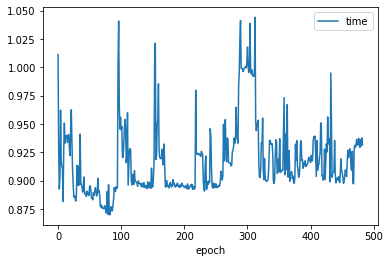

In [31]:
df.plot(kind="line", x="epoch", y="time")

<AxesSubplot:xlabel='epoch'>

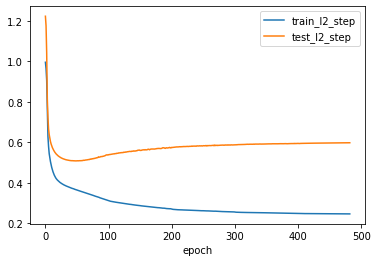

In [32]:
df.plot(kind="line", x="epoch", y=["train_l2_step", "test_l2_step"])

<AxesSubplot:xlabel='epoch'>

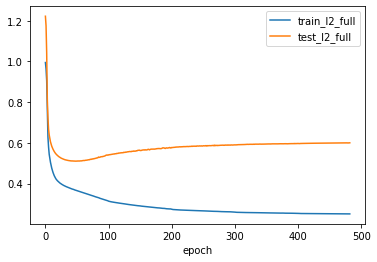

In [33]:
df.plot(kind="line", x="epoch", y=["train_l2_full", "test_l2_full"])

In [37]:
def inference(model, test_loader, T: int, step: int, batch_size: int):
    model.eval()
    with torch.no_grad():
        for xx, yy in test_loader:
            loss = 0
            xx = xx.to(device)
            yy = yy.to(device)

            for t in range(0, T, step):
                y = yy[..., t:t + step]
                im = model(xx)
                loss += myloss(im.reshape(batch_size, -1), y.reshape(batch_size, -1))

                if t == 0:
                    pred = im
                else:
                    pred = torch.cat((pred, im), -1)

                xx = torch.cat((xx[..., step:], im), dim=-1)
            print(xx.shape)

In [38]:
inference(model, test_loader, T, step, batch_size)

torch.Size([128, 28, 28, 10])
torch.Size([72, 28, 28, 10])


In [39]:
len(test_loader)

2

In [40]:
len(train_loader)

8